![Universidad Central](https://aspirantes.ucentral.edu.co/hs-fs/hubfs/logo-reacreditacion-uc-2023.jpg?width=660&height=125&name=logo-reacreditacion-uc-2023.jpg)


__**Entrega 2 -SmartForecasting**__
>**Efren Bohorquez**<br>
>**Jader Gomez**<br>
>**Oscar Tunjano**<br>
>** Descripción: En este cuadernillo se construirán dos modelos LSTM para la predición de inventario de un producto top y uno de media categiría  

In [1]:
!pip install keras_tuner


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# @title 1- Cargue de libreias
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import entropy
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import layers
import keras_tuner as kt
import math


In [3]:
# Limpiar directorio de resultados
import shutil
shutil.rmtree('tuning_results/hyperband_tuning', ignore_errors=True)
shutil.rmtree('tuning_results/random_search_tuning', ignore_errors=True)
shutil.rmtree('tuning_results/bayesian_optimization_tuning', ignore_errors=True)
shutil.rmtree('my_dir', ignore_errors=True)
shutil.rmtree('my_dir_hyperband', ignore_errors=True)

In [4]:
# @title 2- Cargar data set limpia
url = "https://github.com/OscarT231/Proyecto-deep-/raw/refs/heads/main/Base_filtrada.xlsx"
df = pd.read_excel(url)


In [5]:
# --- 1. Fijar semillas para reproducibilidad ( ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
# @title 2.1 Eliminar columnas
df.columns = df.columns.astype(str).str.strip()
columnas_deseadas = [
    "bodega", "producto", "calificacion_abc",
    "2024-09-01 00:00:00","2024-10-01 00:00:00","2024-11-01 00:00:00","2024-12-01 00:00:00",
    "2025-01-01 00:00:00","2025-02-01 00:00:00","2025-03-01 00:00:00","2025-04-01 00:00:00",
    "2025-05-01 00:00:00","2025-06-01 00:00:00","2025-07-01 00:00:00","2025-08-01 00:00:00"
]

df_sugerido = df[[col for col in columnas_deseadas if col in df.columns]].copy()
df_sugerido = df_sugerido[~df_sugerido["calificacion_abc"].isin(["O", "N"])].copy()
df_sugerido.head()

,bodega,producto,calificacion_abc,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,2025-06-01 00:00:00,2025-07-01 00:00:00,2025-08-01 00:00:00
0,BDG-18JWG,P0019,A,1.0,5.0,4.0,0.0,16.0,6.0,9.0,8.0,6.0,3,6.0,10.0
1,BDG-18JWG,P0117,C,4.0,4.0,2.0,0.0,5.0,0.0,3.0,0.0,6.0,2,3.0,4.0
2,BDG-18JWG,P0265,C,2.0,9.0,12.0,0.0,4.0,1.0,16.0,4.0,6.0,0,0.0,0.0
3,BDG-18JWG,P1025,D,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0,0.0,0.0
4,BDG-18JWG,P11031,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0


In [7]:
df= df_sugerido

In [8]:
#@title 2.2 Ajustar el dataset para formato LSTM
# Identificar columnas de fecha (todas excepto bodega, producto, calificación)
id_cols = ["bodega", "producto", "calificacion_abc"]
date_cols = [c for c in df.columns if c not in id_cols]

# Convertir wide → long
df_long = df.melt(id_vars=id_cols,
                  value_vars=date_cols,
                  var_name="fecha",
                  value_name="stock_solicitado")

# Convertir fecha a datetime (formato dd/mm/yyyy)
df_long['fecha'] = pd.to_datetime(df_long['fecha'])

# Ordenar correctamente
df_long = df_long.sort_values(["bodega", "producto", "fecha"])

In [9]:
df_long.head()

,bodega,producto,calificacion_abc,fecha,stock_solicitado
0,BDG-18JWG,P0019,A,2024-09-01,1.0
10841,BDG-18JWG,P0019,A,2024-10-01,5.0
21682,BDG-18JWG,P0019,A,2024-11-01,4.0
32523,BDG-18JWG,P0019,A,2024-12-01,0.0
43364,BDG-18JWG,P0019,A,2025-01-01,16.0


In [9]:
"""
- Se crearán dos bases de datos para los productos top y media categoría
- Se analizarán las bodegas como una sola para después de entrenar y tener el modelo
    utilizar probabilidad (muestreo estratificado) para decidir cuantas unidades van a cada bodega
"""
# @title 2.3 creación de los dos dataset
#df del producto A
df_A = df_long[df_long['producto'].isin(['P9933'])].dropna().reset_index(drop=True)



In [10]:
#df del producto B
df_B = df_long[df_long['producto'].isin(['P2417'])]



In [11]:
df_A["fecha"] = pd.to_datetime(df_A["fecha"])
df_B["fecha"] = pd.to_datetime(df_B["fecha"])

C:\Users\efren\AppData\Local\Temp\ipykernel_120220\2105379917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_B["fecha"] = pd.to_datetime(df_B["fecha"])


In [12]:
df_A.head()

,bodega,producto,calificacion_abc,fecha,stock_solicitado
0,BDG-19GNI,P9933,A,2024-09-01,55.0
1,BDG-19GNI,P9933,A,2024-10-01,64.0
2,BDG-19GNI,P9933,A,2024-11-01,47.0
3,BDG-19GNI,P9933,A,2024-12-01,69.0
4,BDG-19GNI,P9933,A,2025-01-01,47.0


In [13]:
#@title 3- Creación de diccionarios
#DICCIONARIO A
dict_A = {}

for b in df_A["bodega"].unique():
    df_b = df_A[df_A["bodega"] == b][["fecha", "stock_solicitado"]].copy()
    df_b = df_b.sort_values("fecha")

    # Saltar bodegas sin registros útiles
    if df_b["stock_solicitado"].sum() == 0:
        continue

    dict_A[b] = df_b

In [14]:
# DICCIONARIO B
dict_B = {}

for b in df_B["bodega"].unique():
    df_b = df_B[df_B["bodega"] == b][["fecha", "stock_solicitado"]].copy()
    df_b = df_b.sort_values("fecha")

    if df_b["stock_solicitado"].sum() == 0:
        continue

    dict_B[b] = df_b

In [15]:
#@title 4- Normalizar diccionario
#DICCIONARIO A
from sklearn.preprocessing import MinMaxScaler

dict_A_norm = {}
dict_A_scalers = {}

for b, df_b in dict_A.items():
    scaler = MinMaxScaler()

    df_b_norm = df_b.copy()
    df_b_norm["stock_solicitado_s"] = scaler.fit_transform(df_b[["stock_solicitado"]])

    dict_A_norm[b] = df_b_norm
    dict_A_scalers[b] = scaler

In [17]:
#DICCIONARIO B
dict_B_norm = {}
dict_B_scalers = {}

for b, df_b in dict_B.items():
    scaler = MinMaxScaler()

    df_b_norm = df_b.copy()
    df_b_norm["stock_solicitado_s"] = scaler.fit_transform(df_b[["stock_solicitado"]])

    dict_B_norm[b] = df_b_norm
    dict_B_scalers[b] = scaler

In [18]:
dict_A_norm["BDG-19GNI"].head(15)

,fecha,stock_solicitado,stock_solicitado_s
0,2024-09-01,55.0,0.235294
1,2024-10-01,64.0,0.500000
2,2024-11-01,47.0,0.000000
3,2024-12-01,69.0,0.647059
4,2025-01-01,47.0,0.000000
5,2025-02-01,71.0,0.705882
6,2025-03-01,69.0,0.647059
7,2025-04-01,64.0,0.500000
8,2025-05-01,79.0,0.941176
9,2025-06-01,54.0,0.205882


In [21]:
#@title 5- Crear Ventanas
from dateutil.relativedelta import relativedelta

def crear_ventanas_para_df(df_b, fecha_col="fecha", valor_col="stock_solicitado_s",
                           ventana=4, horizonte=1):
    """
    Crea ventanas (X, y) para un DataFrame de una sola bodega.
    - df_b: df con columnas fecha (datetime) y valor_col (normalizado).
    - Devuelve dict con X_seq (n_samples, ventana, 1), y (n_samples, horizonte),
      fecha_end (n_samples,) y n_original (n registros originales).
    - Si no hay suficientes observaciones, devuelve None.
    """
    # Asegurar orden por fecha
    df_b = df_b.sort_values(fecha_col).reset_index(drop=True)
    vals = df_b[valor_col].values
    fechas = pd.to_datetime(df_b[fecha_col].values)

    n = len(df_b)
    min_req = ventana + horizonte
    if n < min_req:
        return None

    X_list, y_list, fecha_end = [], [], []

    # sliding window
    for i in range(n - min_req + 1):
        start = i
        end = i + ventana  # exclusive index for the input window
        target_start = end
        target_end = end + horizonte

        X = vals[start:end].reshape(ventana, 1)        # (ventana, 1)
        y = vals[target_start:target_end].reshape(horizonte,)  # (horizonte,)

        X_list.append(X)
        y_list.append(y)
        fecha_end.append(fechas[end-1])  # fecha del último timestep de la ventana

    return {
        "X_seq": np.array(X_list, dtype=float),
        "y": np.array(y_list, dtype=float),
        "fecha_end": np.array(fecha_end, dtype='datetime64[ns]'),
        "n_original": n
    }


In [22]:
def crear_ventanas_por_diccionario(dict_norm, ventana=6, horizonte=1,
                                   fecha_col="fecha", valor_col="stock_solicitado_s",
                                   min_samples=None):
    """
    Crea un nuevo diccionario con ventanas por bodega.
    - dict_norm: {bodega: df_b}
    - min_samples: umbral mínimo (si None, se asume ventana+horizonte)
    Devuelve:
      seq_dict: {bodega: {"X_seq", "y", "fecha_end", "n_original"}}
    """
    seq_dict = {}
    for bodega, df_b in dict_norm.items():
        out = crear_ventanas_para_df(df_b, fecha_col=fecha_col, valor_col=valor_col,
                                     ventana=ventana, horizonte=horizonte)
        if out is None:
            # opcional: loggear que la bodega se saltó
            # print(f"Saltada bodega {bodega}: menos de {ventana+horizonte} registros.")
            continue

        # chequeo de min_samples si aplica
        if min_samples is not None and out["X_seq"].shape[0] < min_samples:
            # print(f"Saltada bodega {bodega}: menos de {min_samples} muestras (ventanas).")
            continue

        seq_dict[bodega] = out

    return seq_dict


In [23]:
def concatenar_secuencias(seq_dict, ordenar_por_fecha_end=True):
    """
    Concatena todas las ventanas de seq_dict en arrays globales.
    Devuelve X_seq_all, X_bodega_idx, y_all, fecha_ends_all
      - X_seq_all: (N_total, ventana, 1)
      - X_bodega_idx: (N_total,) indices (or labels) of bodegas for each sample
      - y_all: (N_total, horizonte)
      - fecha_ends_all: (N_total,)
    Si ordenar_por_fecha_end True -> ordena globalmente por fecha_end asc.
    """
    b_list = []
    X_list, y_list, f_list = [], [], []

    for b, out in seq_dict.items():
        n = out["X_seq"].shape[0]
        X_list.append(out["X_seq"])
        y_list.append(out["y"])
        f_list.append(out["fecha_end"])
        b_list.extend([b]*n)

    if len(X_list) == 0:
        return None, None, None, None

    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    f_all = np.concatenate(f_list, axis=0)
    b_all = np.array(b_list)

    if ordenar_por_fecha_end:
        order = np.argsort(f_all)
        X_all = X_all[order]
        y_all = y_all[order]
        f_all = f_all[order]
        b_all = b_all[order]

    return X_all, b_all, y_all, f_all

In [24]:
# Paraemetros
ventana = 4
horizonte = 1

In [26]:
#  crear ventanas por bodega para A y B
seq_A = crear_ventanas_por_diccionario(dict_A_norm, ventana=ventana, horizonte=horizonte)
seq_B = crear_ventanas_por_diccionario(dict_B_norm, ventana=ventana, horizonte=horizonte)

print("Bodegas con secuencias en A:", len(seq_A))
print("Bodegas con secuencias en B:", len(seq_B))


Bodegas con secuencias en A: 28
Bodegas con secuencias en B: 24


In [27]:
# @title 6- Crear split
""""
el split temporal por bodega sirve para separar los datos de Cada bodega en train / val / test
respetando su propia línea de tiempo, no la del dataset completo.
"""


'"\nel split temporal por bodega sirve para separar los datos de Cada bodega en train / val / test\nrespetando su propia línea de tiempo, no la del dataset completo.\n'

In [28]:
#Split temporal por una bodega
from dateutil.relativedelta import relativedelta
def temporal_split_por_bodega(fecha_ends, test_months=2, val_months=2):
    """
    Dado un array de fechas (fecha_end) de UNA bodega,
    devuelve los boolean masks para train / val / test.
    """
    fecha_ends = pd.to_datetime(fecha_ends)
    max_fecha = fecha_ends.max()

    # Cortes temporales para esta bodega
    test_start = max_fecha - relativedelta(months=test_months)
    val_start = max_fecha - relativedelta(months=(test_months + val_months))

    # Máscaras
    mask_test  = fecha_ends > test_start
    mask_val   = (fecha_ends > val_start) & (fecha_ends <= test_start)
    mask_train = fecha_ends <= val_start

    return mask_train, mask_val, mask_test

In [29]:
# Split para todo el diccionario

def split_por_bodega(seq_dict, test_months=2, val_months=2):
    """
    Aplica el split temporal por bodega a todo el diccionario de secuencias.
    Retorna un nuevo diccionario con los splits por bodega.
    """
    split_dict = {}

    for bodega, datos in seq_dict.items():

        fechas = datos["fecha_end"]
        X = datos["X_seq"]
        y = datos["y"]

        # Obtener máscaras específicas para esta bodega
        mask_train, mask_val, mask_test = temporal_split_por_bodega(
            fechas,
            test_months=test_months,
            val_months=val_months
        )

        # Guardar las particiones
        split_dict[bodega] = {
            "X_train":  X[mask_train],
            "y_train":  y[mask_train],
            "fechas_train": fechas[mask_train],

            "X_val":    X[mask_val],
            "y_val":    y[mask_val],
            "fechas_val": fechas[mask_val],

            "X_test":   X[mask_test],
            "y_test":   y[mask_test],
            "fechas_test": fechas[mask_test],
        }

    return split_dict

In [30]:
seq_A = crear_ventanas_por_diccionario(dict_A_norm, ventana=4, horizonte=1)
seq_B = crear_ventanas_por_diccionario(dict_B_norm, ventana=4, horizonte=1)

In [31]:
split_A = split_por_bodega(seq_A, test_months=2, val_months=2)
split_B = split_por_bodega(seq_B, test_months=2, val_months=2)

In [33]:
# @title 7- Construcción del modelo con Keras Tuner
def build_lstm_model(hp, input_shape):
    model = keras.Sequential()

    # 1) Número de unidades LSTM por capa
    units = hp.Int("units", min_value=16, max_value=64, step=16)

    # 2) Número de capas LSTM apiladas
    num_lstm_layers = hp.Int("num_lstm_layers", min_value=1, max_value=2)

    # 3) Dropout (mismo valor en todas las capas)
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.1)

    # Construcción de las capas LSTM
    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)

        if i == 0:
            model.add(
                layers.LSTM(
                    units=units,
                    return_sequences=return_sequences,
                    input_shape=input_shape
                )
            )
        else:
            model.add(
                layers.LSTM(
                    units=units,
                    return_sequences=return_sequences
                )
            )

    # Dropout global
    model.add(layers.Dropout(dropout_rate))

    # Capa densa intermedia opcional
    dense_units = hp.Int("dense_units", min_value=0, max_value=64, step=16)
    if dense_units > 0:
        model.add(layers.Dense(dense_units, activation="relu"))

    # Capa de salida
    model.add(layers.Dense(1))

    # 5) Tasa de aprendizaje
    learning_rate = hp.Choice(
        "learning_rate",
        values=[1e-4, 5e-4, 1e-3, 5e-3]
    )

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model


In [34]:
# @title 8- Entrenamiento automático
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Crear carpeta de modelos
os.makedirs("modelos_entrenados", exist_ok=True)

# Diccionarios a recorrer - CORRECTED to use split_A and split_B
dicts = {
    "A": split_A,
    "B": split_B
}

for nombre_modelo, dataset_dict in dicts.items():

    print(f"\n============================")
    print(f" ENTRENANDO MODELO {nombre_modelo}")
    print(f"============================\n")

    for bodega, splits in dataset_dict.items():

        print(f"\n--> Entrenando para bodega {bodega}")

        X_train = splits["X_train"]
        y_train = splits["y_train"]
        X_val   = splits["X_val"]
        y_val   = splits["y_val"]

        input_shape = (X_train.shape[1], X_train.shape[2])

        # -----------------------------
        # KERAS TUNER
        # -----------------------------
        tuner = kt.RandomSearch(
            lambda hp: build_lstm_model(hp, input_shape),
            objective="val_loss",
            max_trials=8,
            directory="tuner_results",
            project_name=f"tuner_{nombre_modelo}_{bodega}"
        )

        tuner.search(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
            ],
            verbose=0
        )

        # Mejor hiperparámetros
        best_hp = tuner.get_best_hyperparameters(1)[0]
        model = tuner.hypermodel.build(best_hp)

        # -----------------------------
        # ENTRENAMIENTO FINAL
        # -----------------------------
        ruta_guardado = f"modelos_entrenados/modelo_{nombre_modelo}_bodega_{bodega}.keras"

        checkpoint = ModelCheckpoint(
            ruta_guardado,
            monitor="val_loss",
            save_best_only=True,
            mode="min"
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
                checkpoint
            ],
            verbose=0
        )

        print(f"   ✔ Modelo guardado como: {ruta_guardado}")



 ENTRENANDO MODELO A


--> Entrenando para bodega BDG-19GNI
Reloading Tuner from tuner_results\tuner_A_BDG-19GNI\tuner0.json


c:\Users\efren\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   ✔ Modelo guardado como: modelos_entrenados/modelo_A_bodega_BDG-19GNI.keras

--> Entrenando para bodega BDG-1EEXV
Reloading Tuner from tuner_results\tuner_A_BDG-1EEXV\tuner0.json
   ✔ Modelo guardado como: modelos_entrenados/modelo_A_bodega_BDG-1EEXV.keras

--> Entrenando para bodega BDG-1GFVI
Reloading Tuner from tuner_results\tuner_A_BDG-1GFVI\tuner0.json
   ✔ Modelo guardado como: modelos_entrenados/modelo_A_bodega_BDG-1GFVI.keras

--> Entrenando para bodega BDG-1R0Z2
Reloading Tuner from tuner_results\tuner_A_BDG-1R0Z2\tuner0.json
   ✔ Modelo guardado como: modelos_entrenados/modelo_A_bodega_BDG-1R0Z2.keras

--> Entrenando para bodega BDG-20UVR
Reloading Tuner from tuner_results\tuner_A_BDG-20UVR\tuner0.json
   ✔ Modelo guardado como: modelos_entrenados/modelo_A_bodega_BDG-20UVR.keras

--> Entrenando para bodega BDG-24Q8N
Reloading Tuner from tuner_results\tuner_A_BDG-24Q8N\tuner0.json
   ✔ Modelo guardado como: modelos_entrenados/modelo_A_bodega_BDG-24Q8N.keras

--> Entrenando p

In [30]:
#@title 9- Evaluar modelos

def evaluar_modelos(dict_modelos, nombre_diccionario, carpeta="modelos_entrenados"):
    """
    dict_modelos: seq_A o seq_B
    nombre_diccionario: "A" o "B"
    """

    resultados = []

    for bodega, splits in dict_modelos.items():

        ruta = os.path.join(carpeta, f"modelo_{nombre_diccionario}_bodega_{bodega}.keras")

        if not os.path.exists(ruta):
            print(f"No existe modelo para bodega {bodega}")
            continue

        # Cargar modelo
        model = tf.keras.models.load_model(ruta)

        # Evaluar
        X_test = splits["X_test"]
        y_test = splits["y_test"]

        loss, mae = model.evaluate(X_test, y_test, verbose=0)

        # Extraer hiperparámetros limpios directamente
        hp_clean = {}
        try:
            model_architecture_config = model.get_config()
            # Search for LSTM layer to get units
            for layer_config in model_architecture_config["layers"]:
                if layer_config["class_name"] == "LSTM":
                    hp_clean["lstm_units"] = layer_config["config"]["units"]
                    # Dropout is not tuned, defaults to 0 if not present
                    hp_clean["lstm_dropout"] = layer_config["config"].get("dropout", 0.0)
                    break
        except Exception as e:
            print(f"Error extracting LSTM units for {bodega}: {e}")

        try:
            # Get learning rate from the loaded model's optimizer
            if hasattr(model, 'optimizer') and hasattr(model.optimizer, 'learning_rate'):
                # Keras 3 learning_rate can be a callable schedule
                if callable(model.optimizer.learning_rate):
                    # Pass optimizer.iterations to get current LR if it's a schedule
                    hp_clean["learning_rate"] = float(model.optimizer.learning_rate(model.optimizer.iterations).numpy())
                else:
                    hp_clean["learning_rate"] = float(model.optimizer.learning_rate.numpy())
            else:
                hp_clean["learning_rate"] = None
        except Exception as e:
            print(f"Error extracting learning rate for {bodega}: {e}")
            hp_clean["learning_rate"] = None

        resultados.append({
            "diccionario": nombre_diccionario,
            "bodega": bodega,
            "loss": loss,
            "mae": mae,
            "hp": hp_clean # Store the cleaned HPs directly here
        })

    return resultados

In [31]:
resultados_A = evaluar_modelos(split_A, "A")
resultados_B = evaluar_modelos(split_B, "B")

In [32]:
df_res_A = pd.DataFrame(resultados_A).sort_values("mae")
df_res_B = pd.DataFrame(resultados_B).sort_values("mae")

print("TOP MODELOS A:")
print(df_res_A.head(28))

print("\nTOP MODELOS B:")
display(df_res_B.head(24))

TOP MODELOS A:
   diccionario     bodega          loss           mae  \
1            A  BDG-1EEXV  1.046528e-16  1.023000e-08   
11           A  BDG-3V4LT  1.612407e-09  4.015479e-05   
21           A  BDG-66SKL  4.453637e-08  2.110364e-04   
2            A  BDG-1GFVI  6.598530e-06  2.568760e-03   
23           A  BDG-BS84U  1.744732e-05  3.110439e-03   
27           A  BDG-WR6VI  8.250564e-05  9.083262e-03   
16           A  BDG-4QZTN  3.748224e-04  1.931169e-02   
19           A  BDG-5MDWK  1.204247e-02  1.095234e-01   
4            A  BDG-20UVR  1.924900e-02  1.214633e-01   
13           A  BDG-43ZU5  1.496503e-02  1.222622e-01   
10           A  BDG-3QI70  1.952545e-02  1.280979e-01   
20           A  BDG-5Y9N3  3.483526e-02  1.764870e-01   
15           A  BDG-48TAP  4.202038e-02  1.860989e-01   
26           A  BDG-W61BM  5.290953e-02  1.885505e-01   
24           A  BDG-P0FGZ  8.175923e-02  2.603396e-01   
0            A  BDG-19GNI  1.181708e-01  3.038221e-01   
7            A  

,diccionario,bodega,loss,mae,hp
18,B,BDG-5JF9D,1.831748e-09,0.000043,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
2,B,BDG-1DCZW,1.914461e-08,0.000138,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
17,B,BDG-4WWK2,8.424367e-08,0.000290,"{'lstm_units': 64, 'lstm_dropout': 0.0, 'learn..."
22,B,BDG-W61BM,2.000310e-06,0.001414,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
6,B,BDG-1R7WO,1.725585e-05,0.004154,"{'lstm_units': 64, 'lstm_dropout': 0.0, 'learn..."
13,B,BDG-46UXE,3.057192e-05,0.004271,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
11,B,BDG-3ZX47,1.100266e-02,0.080708,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
1,B,BDG-19GNI,9.412014e-03,0.096525,"{'lstm_units': 64, 'lstm_dropout': 0.0, 'learn..."
14,B,BDG-4M0CY,1.626804e-02,0.098440,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
7,B,BDG-21NV0,1.793175e-02,0.131090,"{'lstm_units': 64, 'lstm_dropout': 0.0, 'learn..."


In [33]:
#@ 10- Extraer hiperparámetros
def extraer_hp(model_config):
    """Devuelve solo lo importante del modelo."""
    if model_config is None:
        return {}

    hp = {}

    # Buscar capa LSTM
    for layer in model_config["layers"]:
        if "class_name" in layer and layer["class_name"] == "LSTM":
            hp["lstm_units"] = layer["config"]["units"]
            hp["lstm_dropout"] = layer["config"]["dropout"]

    # Buscar optimizador
    opt = model_config["compile_config"]["optimizer_config"]["config"]
    hp["learning_rate"] = opt.get("learning_rate", None)

    return hp

In [34]:
df_res_A["hp_clean"] = df_res_A["hp"]
df_res_B["hp_clean"] = df_res_B["hp"]

In [35]:
df_res_A[["bodega", "mae", "hp_clean"]].head()

,bodega,mae,hp_clean
1,BDG-1EEXV,1.023000e-08,"{'lstm_units': 32, 'lstm_dropout': 0.0, 'learn..."
11,BDG-3V4LT,4.015479e-05,"{'lstm_units': 64, 'lstm_dropout': 0.0, 'learn..."
21,BDG-66SKL,2.110364e-04,"{'lstm_units': 48, 'lstm_dropout': 0.0, 'learn..."
2,BDG-1GFVI,2.568760e-03,"{'lstm_units': 16, 'lstm_dropout': 0.0, 'learn..."
23,BDG-BS84U,3.110439e-03,"{'lstm_units': 16, 'lstm_dropout': 0.0, 'learn..."


In [36]:
# @title 10- Exportar a un csv
# The 'hp' column now contains the cleaned hyperparameters after re-running the evaluation cells.
df_res_A["hp_clean"] = df_res_A["hp"]
df_res_B["hp_clean"] = df_res_B["hp"]

In [37]:
# Seleccionar columnas importantes
cols = ["diccionario", "bodega", "mae", "loss", "hp_clean"]

# Exportar modelos del diccionario A
df_res_A[cols].to_csv("mejores_modelos_A.csv", index=False)

# Exportar modelos del diccionario B
df_res_B[cols].to_csv("mejores_modelos_B.csv", index=False)

print("Archivos exportados:\n- mejores_modelos_A.csv\n- mejores_modelos_B.csv")

Archivos exportados:
- mejores_modelos_A.csv
- mejores_modelos_B.csv


In [38]:
#@title 11- Predicciones futuras
def predecir_futuro_por_bodega(
        dict_splits,        # seq_A o seq_B
        dict_series,        # dict_A_series o dict_B_series
        dict_scalers,       # scalers_A o scalers_B
        nombre_diccionario, # "A" o "B"
        carpeta_modelos="modelos_entrenados"
    ):

    resultados = []

    for bodega in dict_splits.keys():

        # -------------------
        # 1. Cargar modelo
        # -------------------
        ruta_modelo = os.path.join(carpeta_modelos, f"modelo_{nombre_diccionario}_bodega_{bodega}.keras")
        if not os.path.exists(ruta_modelo):
            print(f"Modelo NO encontrado para bodega {bodega} ({nombre_diccionario})")
            continue

        model = tf.keras.models.load_model(ruta_modelo)

        # -------------------
        # 2. Obtener última ventana de esa bodega
        # -------------------
        serie = dict_series[bodega]["stock_solicitado_s"].values # Corrected column name
        ventana_size = list(dict_splits[bodega]["X_test"].shape)[1]  # tamaño de ventana usado

        if len(serie) < ventana_size:
            print(f"Bodega {bodega}: serie muy corta para predicción futura.")
            continue

        ultima_ventana = serie[-ventana_size:].reshape(1, ventana_size, 1)

        # -------------------
        # 3. Predecir futuro
        # -------------------
        pred_scaled = model.predict(ultima_ventana, verbose=0)[0]

        # -------------------
        # 4. Invertir escala
        # -------------------
        scaler = dict_scalers[bodega]
        pred_real = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]

        # -------------------
        # 5. Guardar resultado
        # -------------------
        resultados.append({
            "diccionario": nombre_diccionario,
            "bodega": bodega,
            "pred_scaled": float(pred_scaled[0]),
            "pred_real": float(pred_real)
        })

    return pd.DataFrame(resultados)

In [39]:
pred_A = predecir_futuro_por_bodega(
    dict_splits=split_A,
    dict_series=dict_A_norm,
    dict_scalers=dict_A_scalers,
    nombre_diccionario="A"
)

pred_B = predecir_futuro_por_bodega(
    dict_splits=split_B,
    dict_series=dict_B_norm,
    dict_scalers=dict_B_scalers,
    nombre_diccionario="B"
)

In [40]:
#@title 12- graficar predicció vs historia
import matplotlib.pyplot as plt
import pandas as pd

def graficar_bodega(
        dict_series,     # dict_A_series o dict_B_series
        df_pred,         # pred_A o pred_B
        bodega,
        titulo_prefix=""
    ):

    if bodega not in dict_series:
        print(f"Bodega {bodega} no existe en el diccionario de series.")
        return

    # Serie histórica real
    serie = dict_series[bodega].copy()

    # Agregar predicción futura
    try:
        pred = df_pred[df_pred["bodega"] == bodega]["pred_real"].values[0]
    except:
        print(f"No hay predicción para bodega {bodega}")
        return

    # Crear fila futura
    fecha_futura = serie["fecha"].max() + pd.DateOffset(months=1)

    df_plot = serie.copy()
    df_plot["tipo"] = "historia"

    df_fut = pd.DataFrame({
        "fecha": [fecha_futura],
        "stock_solicitado": [pred],
        "serie_s": [None],
        "tipo": ["predicción"]
    })

    df_plot = pd.concat([df_plot, df_fut], ignore_index=True)

    # Graficar
    plt.figure(figsize=(12, 5))
    plt.plot(
        df_plot[df_plot["tipo"] == "historia"]["fecha"],
        df_plot[df_plot["tipo"] == "historia"]["stock_solicitado"],
        label="Historia",
        linewidth=2
    )
    plt.scatter(
        df_plot[df_plot["tipo"] == "predicción"]["fecha"],
        df_plot[df_plot["tipo"] == "predicción"]["stock_solicitado"],
        color="red",
        label="Predicción Próximo Mes",
        s=100
    )

    plt.title(f"{titulo_prefix} Bodega {bodega} — Predicción vs Historia")
    plt.xlabel("Fecha")
    plt.ylabel("Stock Solicitado")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


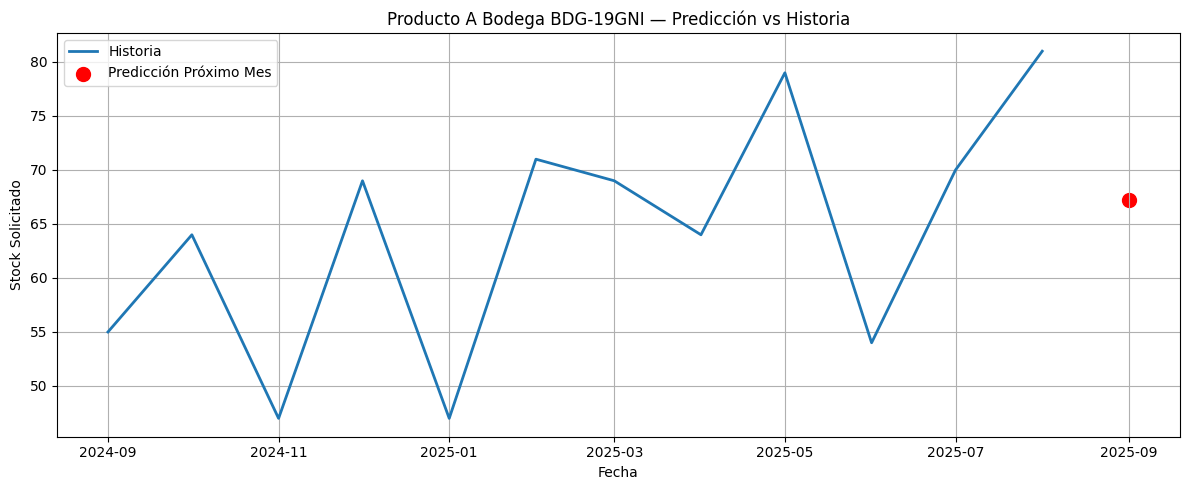

In [43]:
graficar_bodega(dict_series=dict_A_norm, df_pred=pred_A, bodega="BDG-19GNI", titulo_prefix="Producto A")

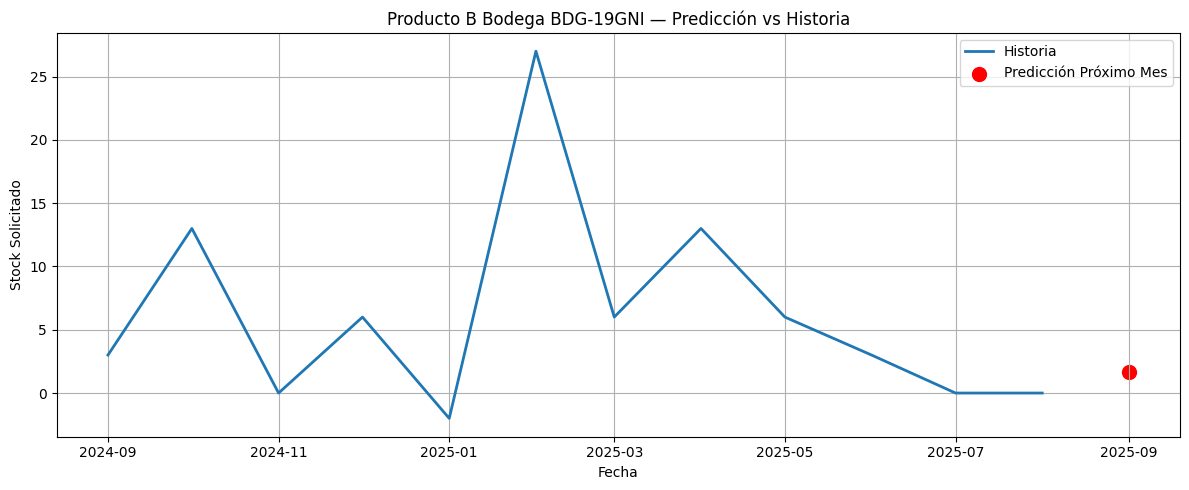

In [44]:
graficar_bodega(dict_series=dict_B_norm, df_pred=pred_B, bodega="BDG-19GNI", titulo_prefix="Producto B")

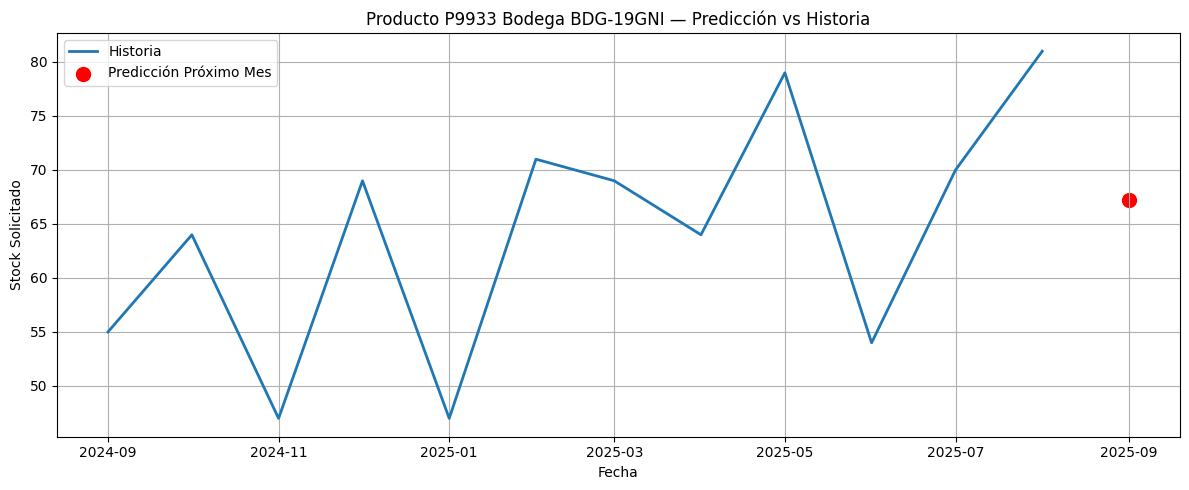

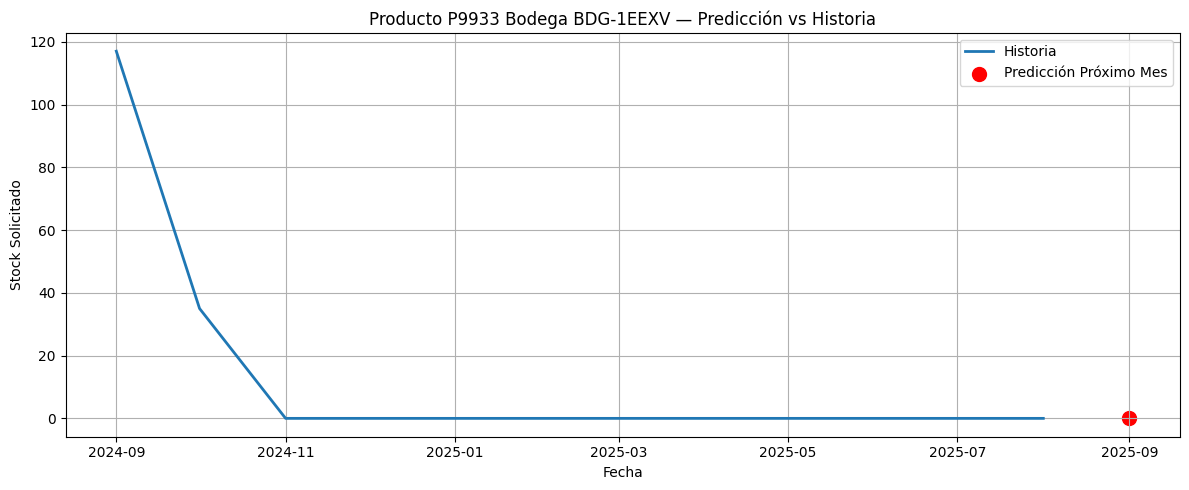

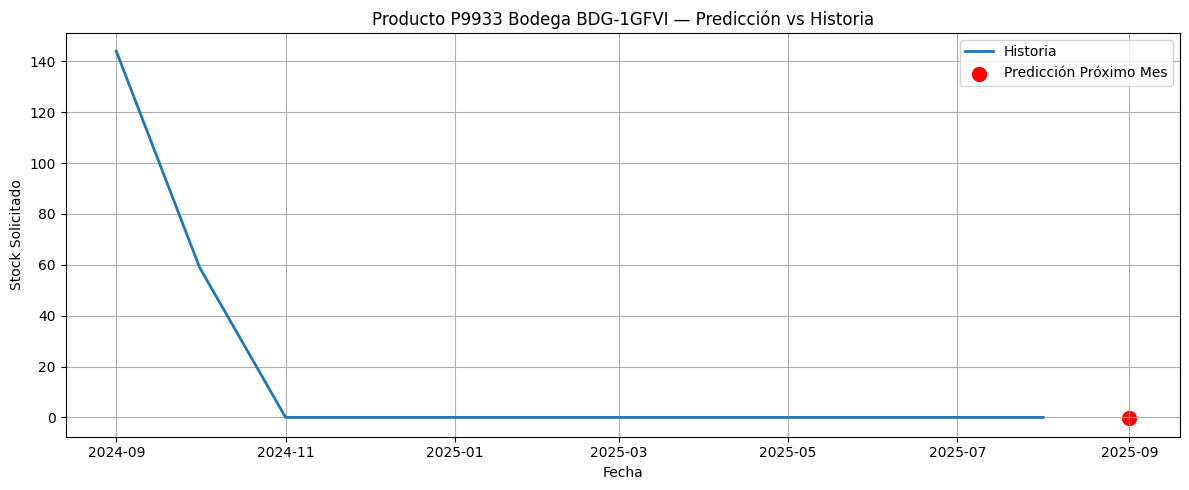

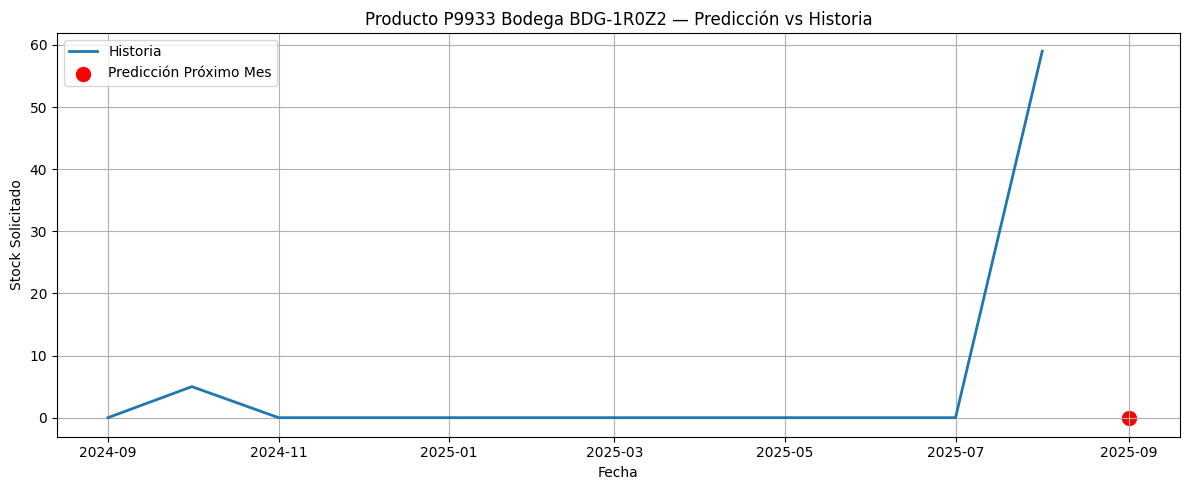

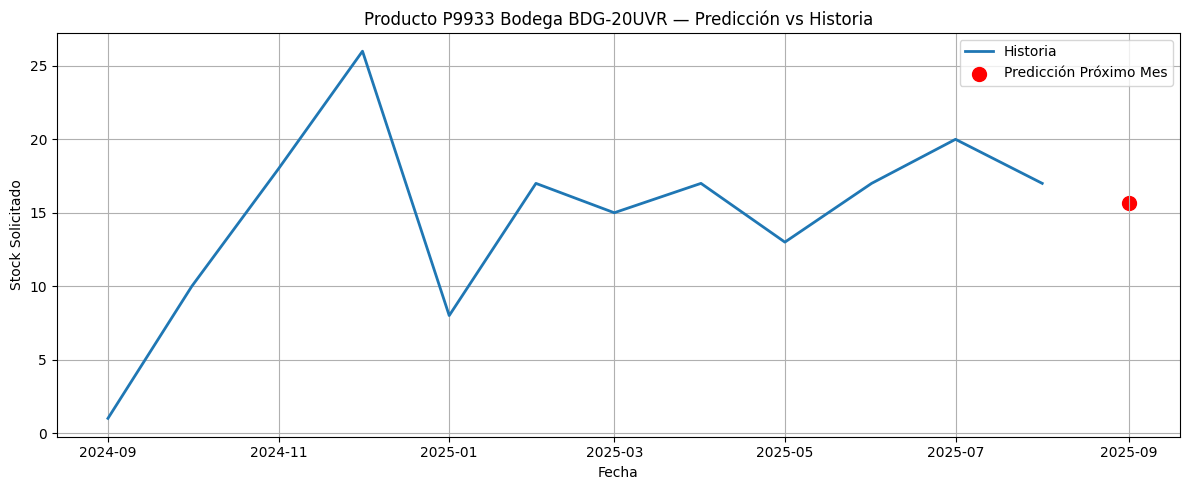

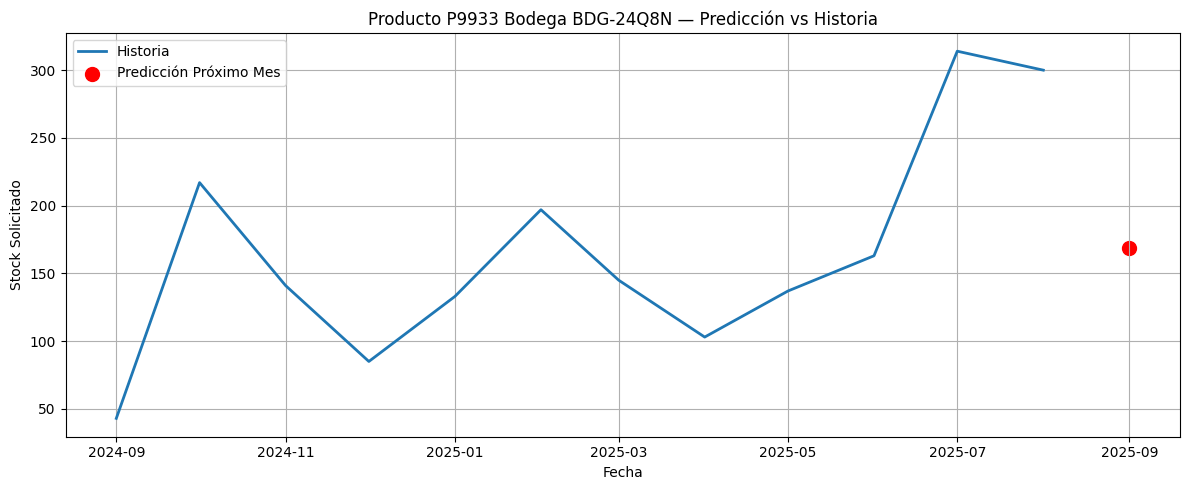

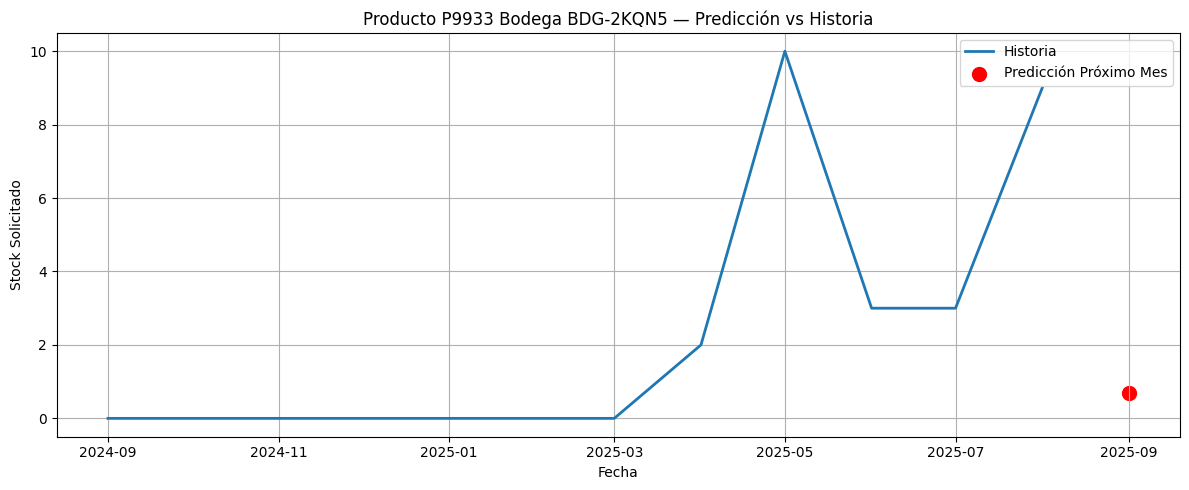

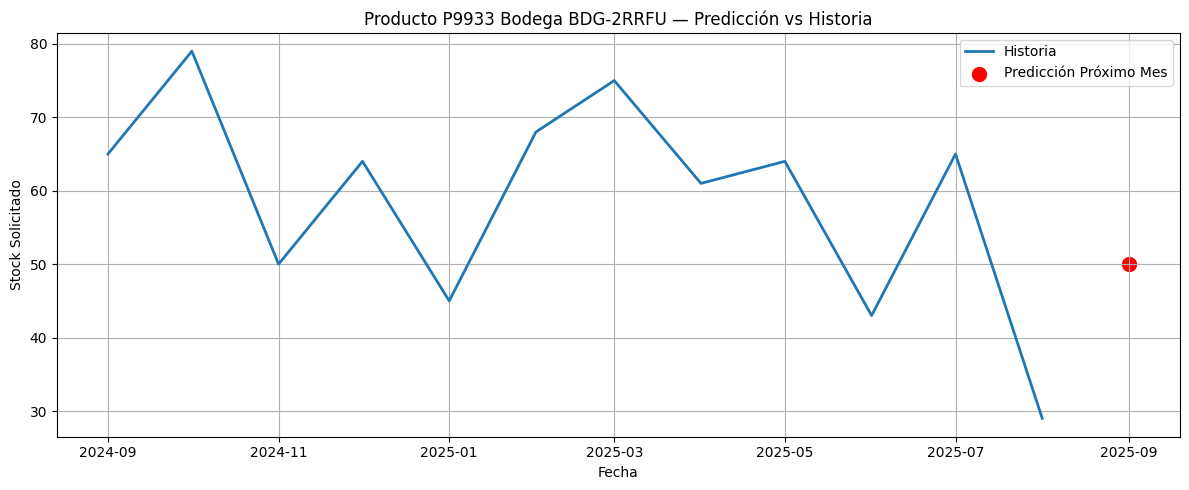

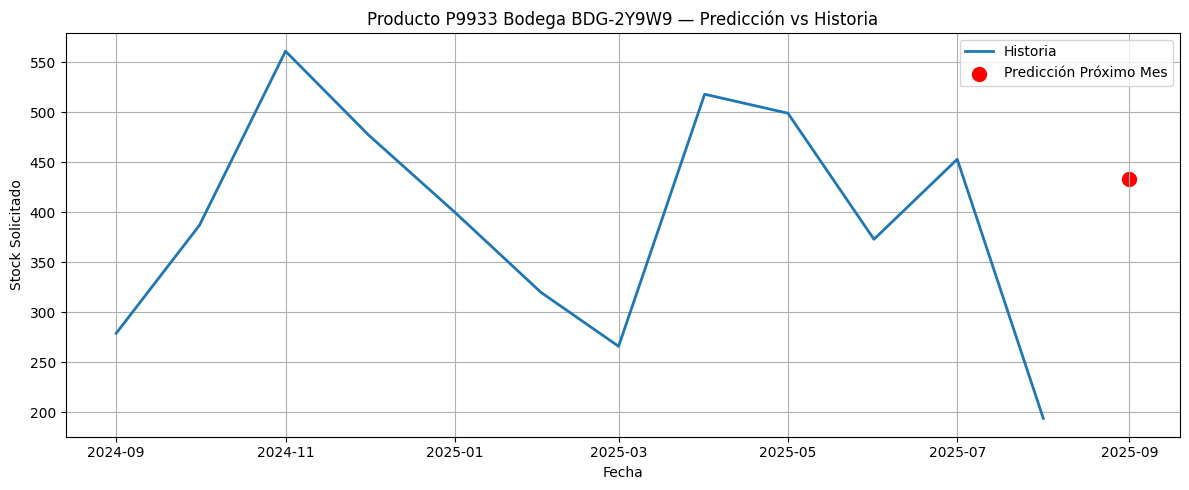

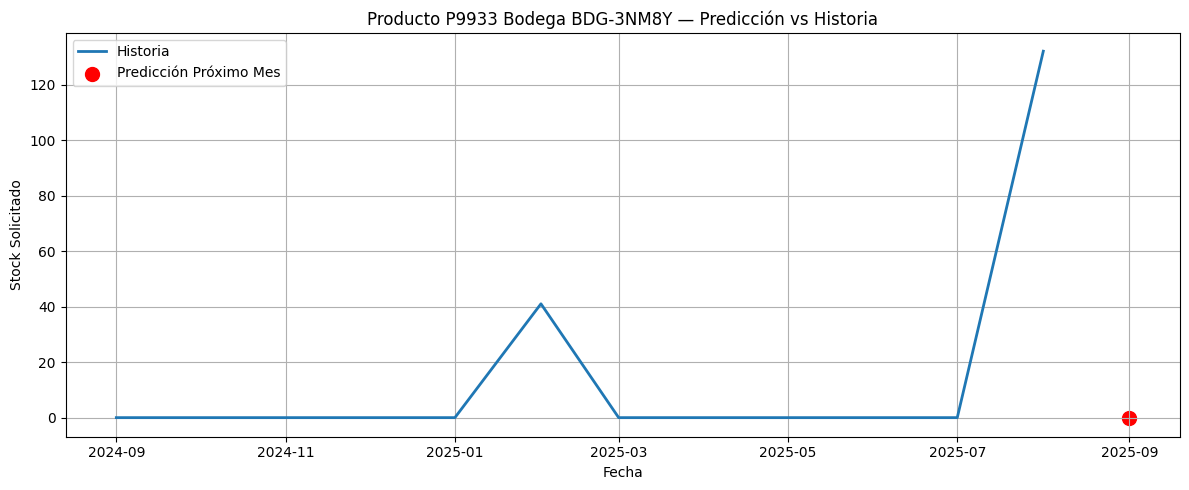

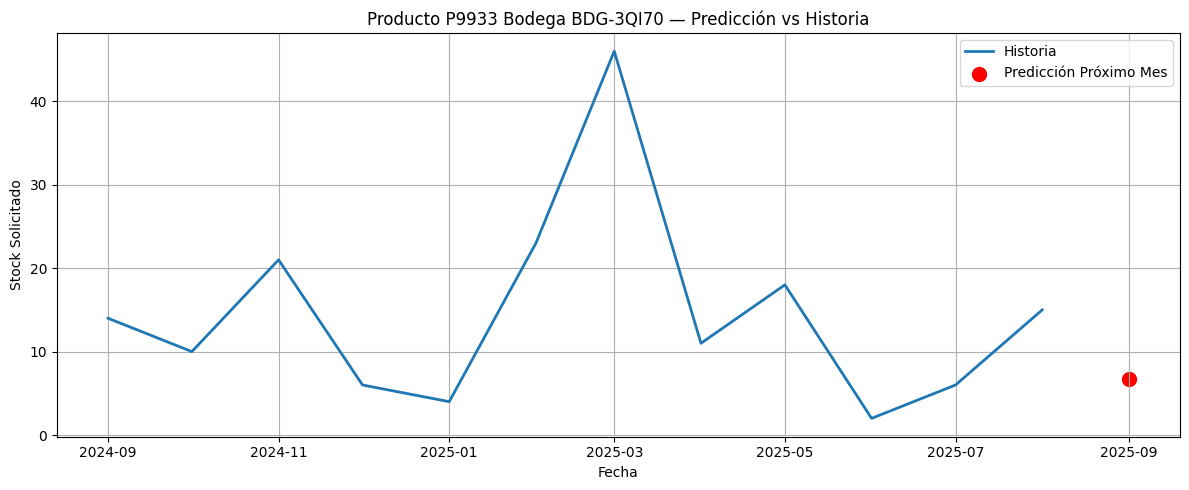

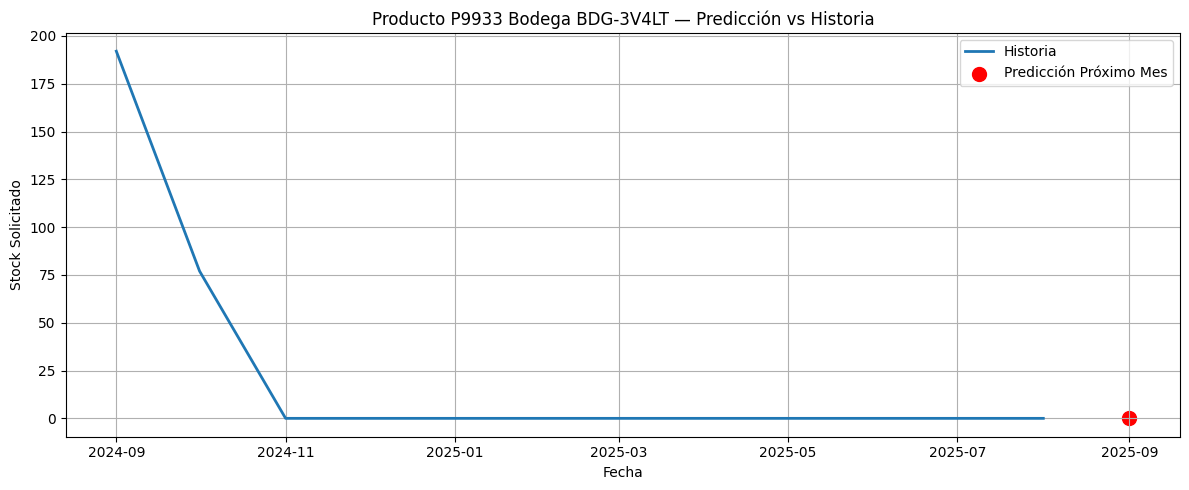

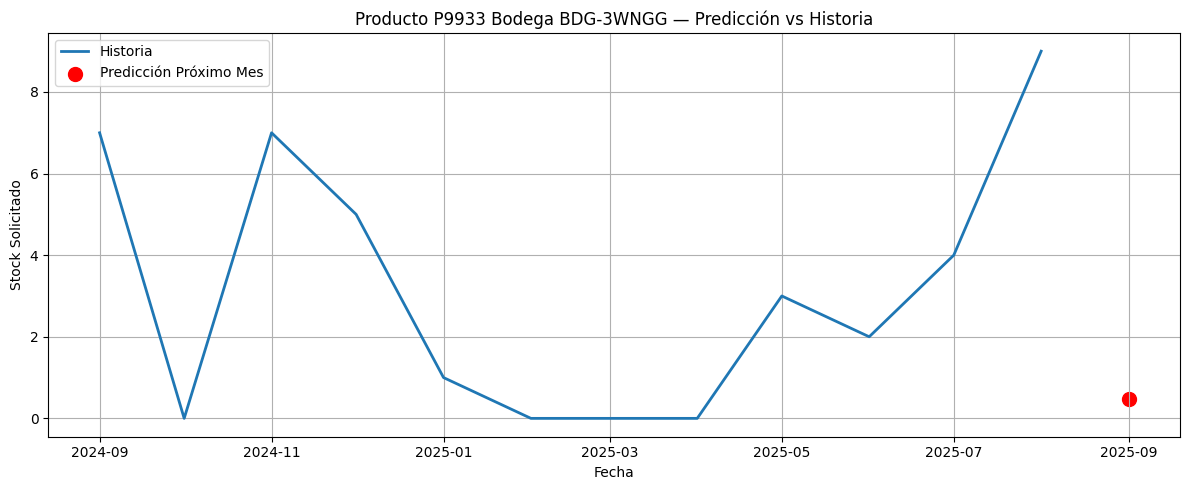

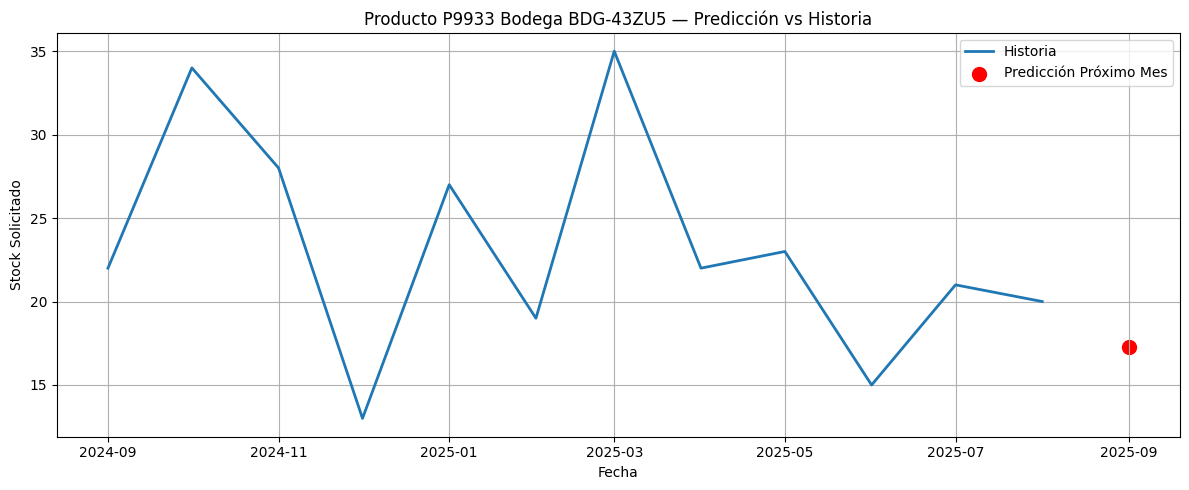

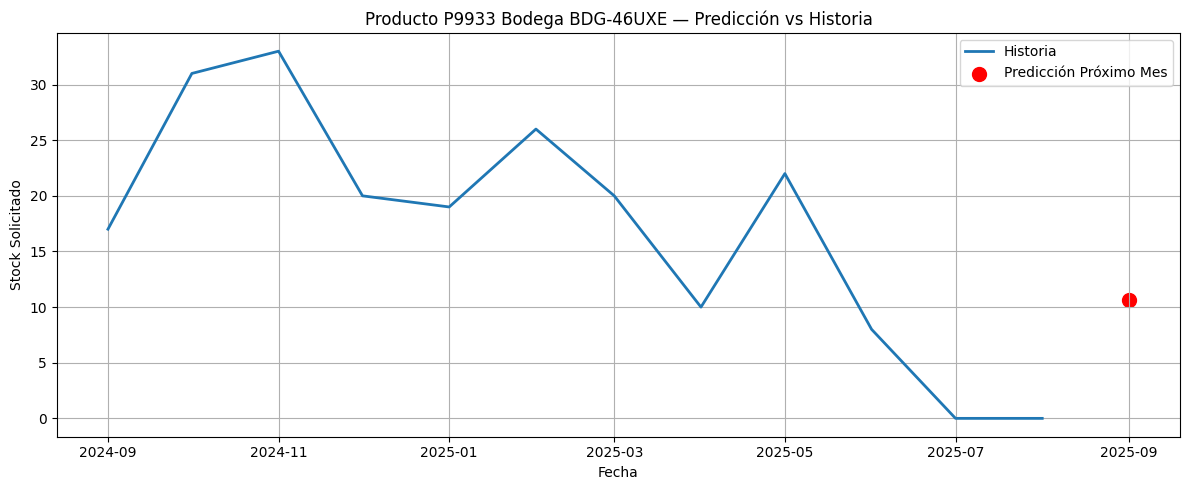

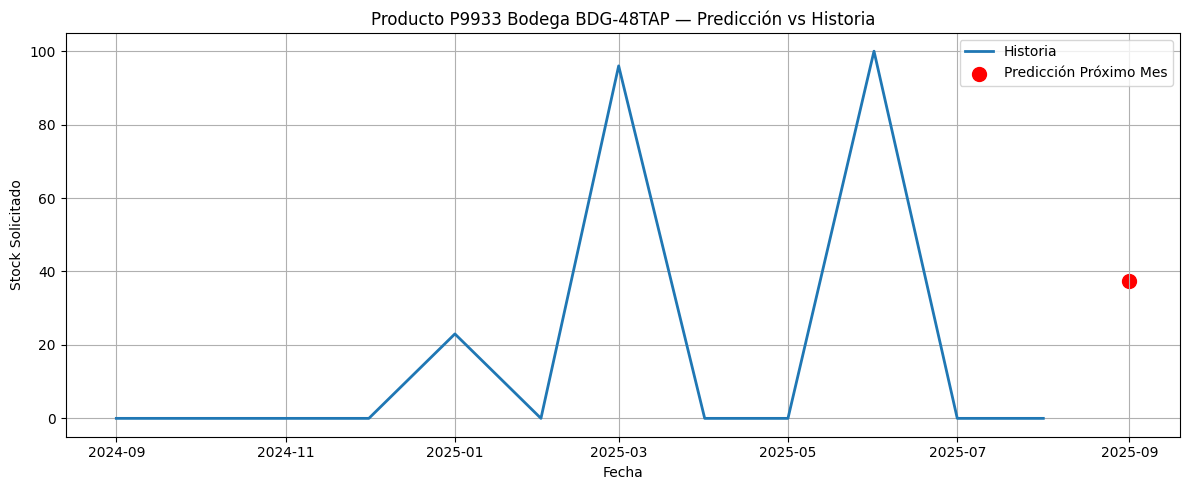

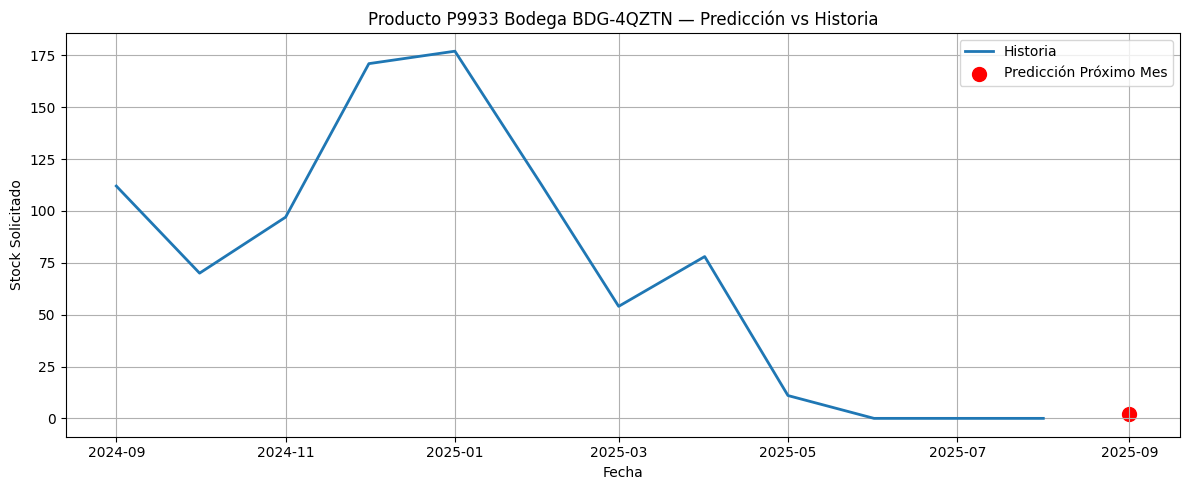

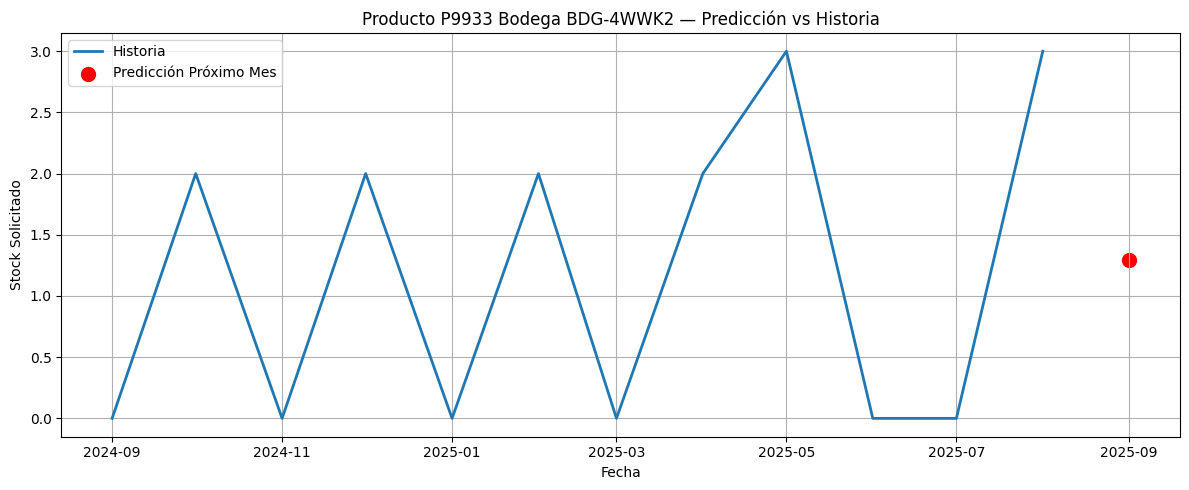

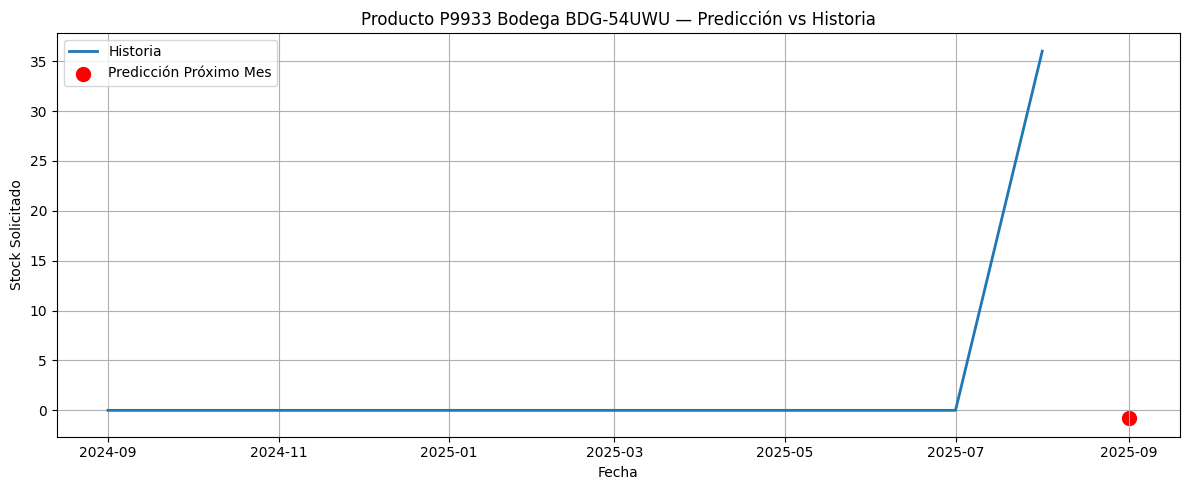

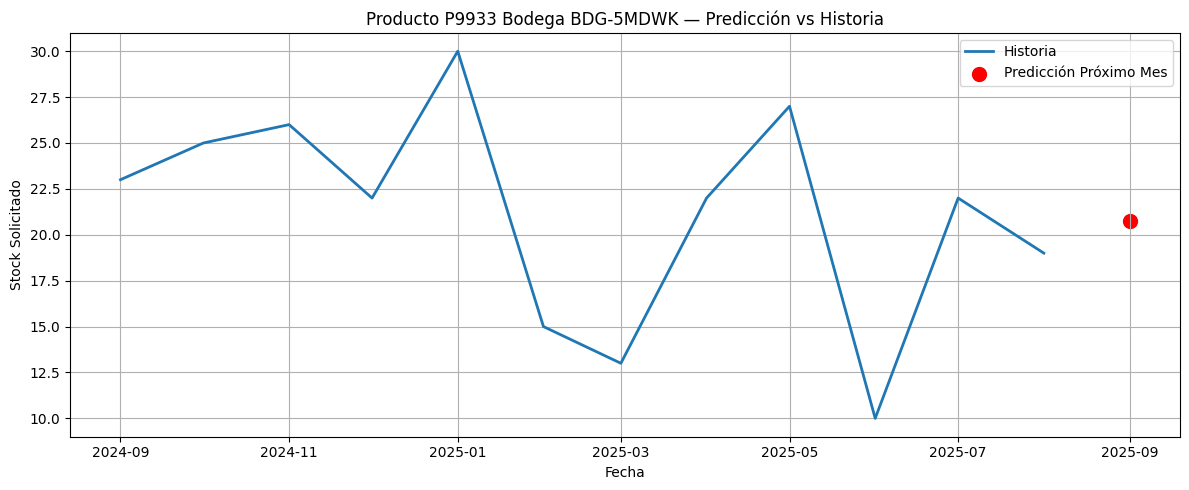

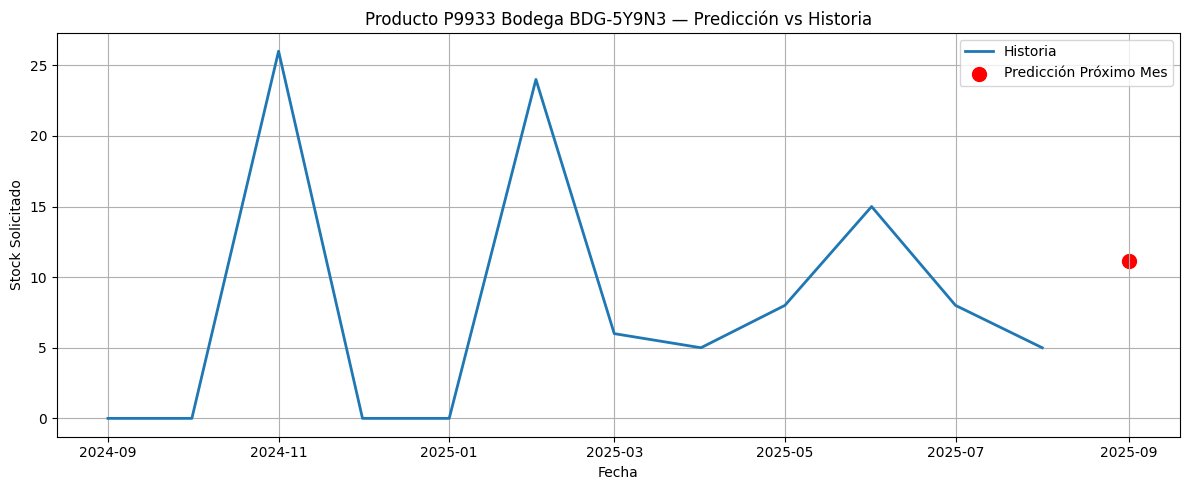

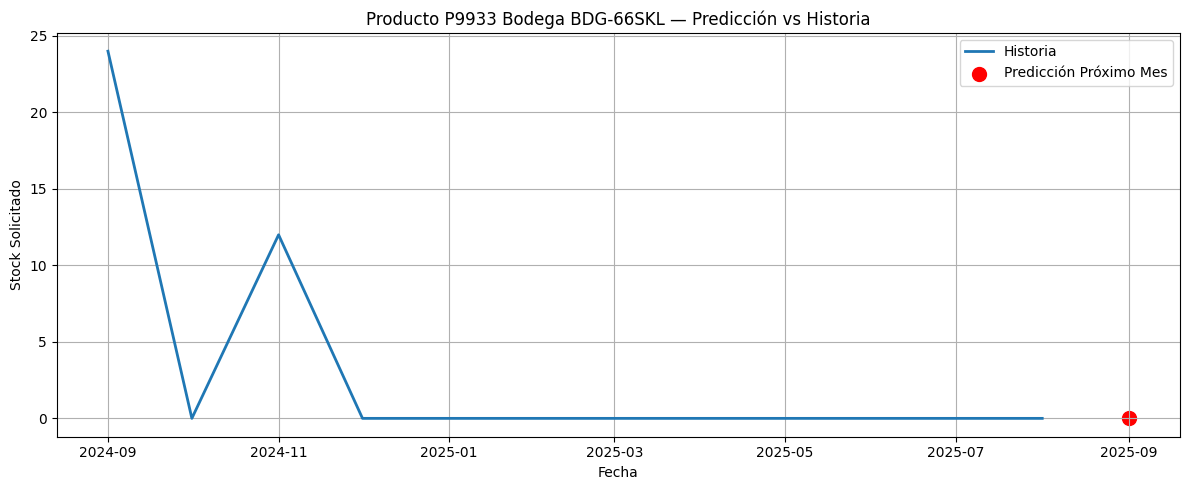

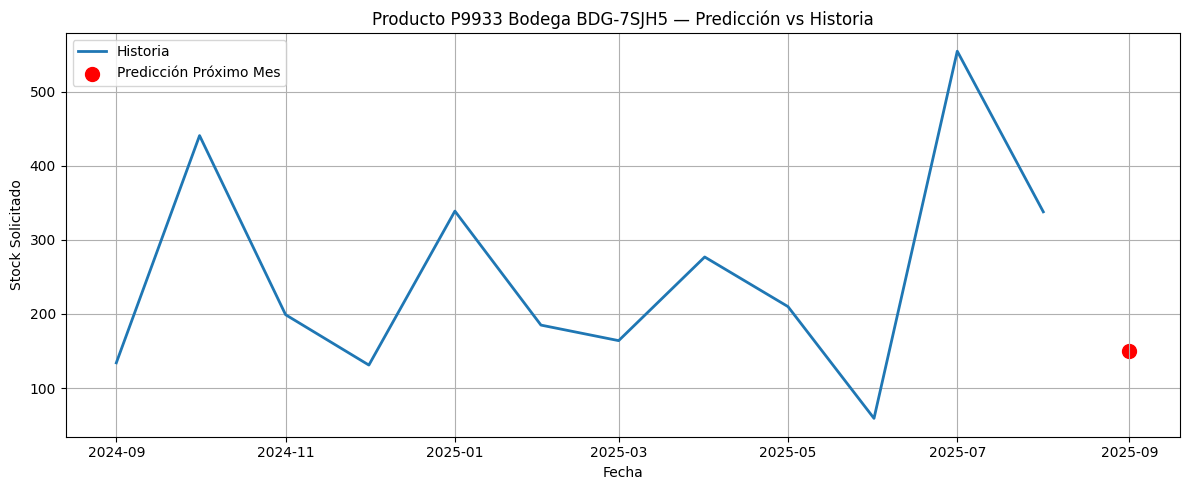

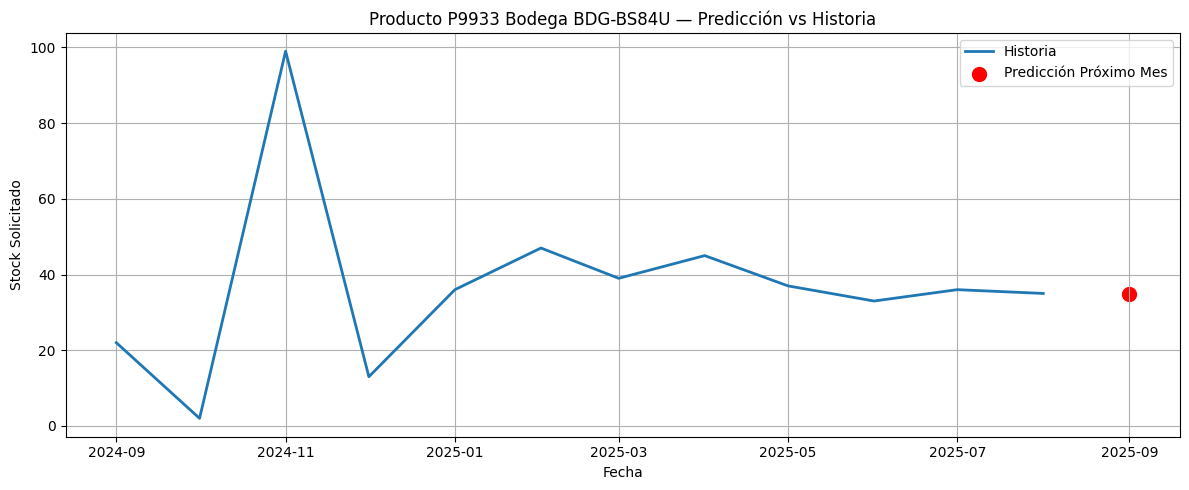

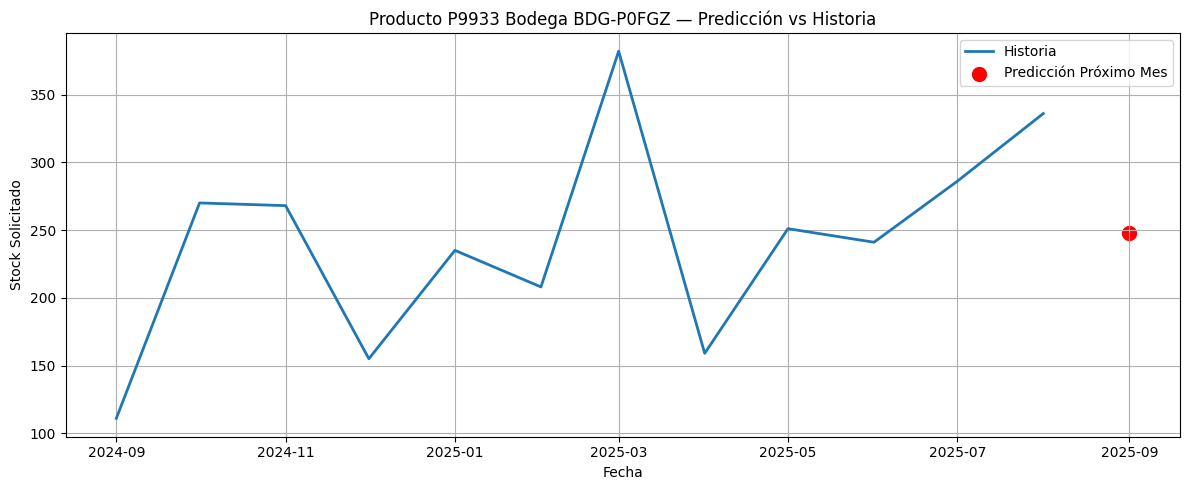

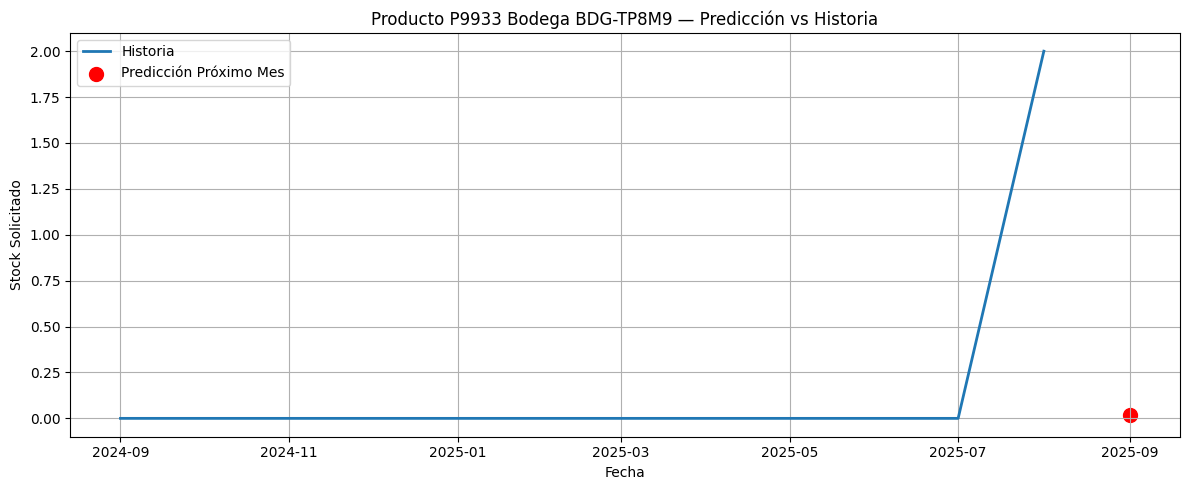

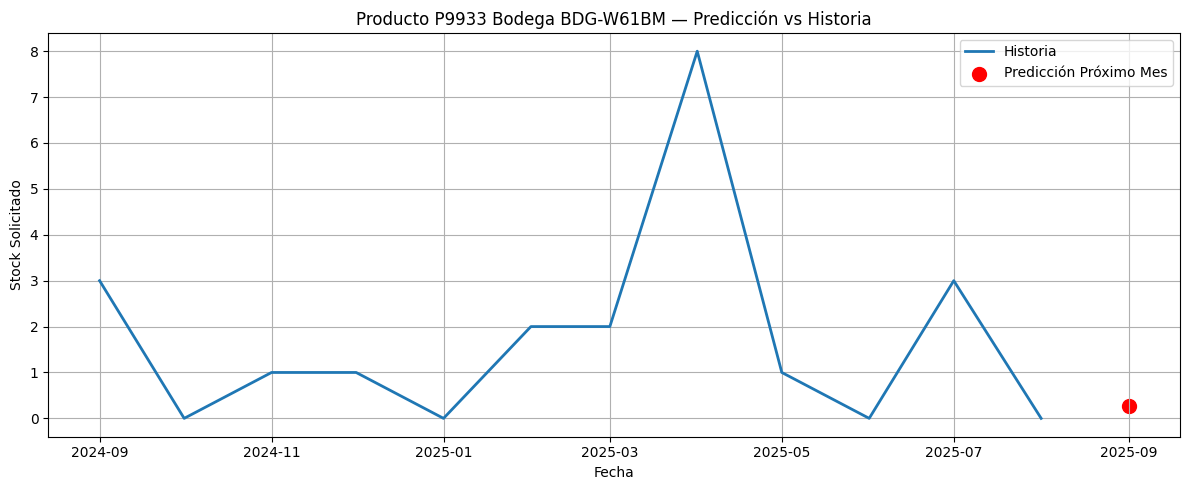

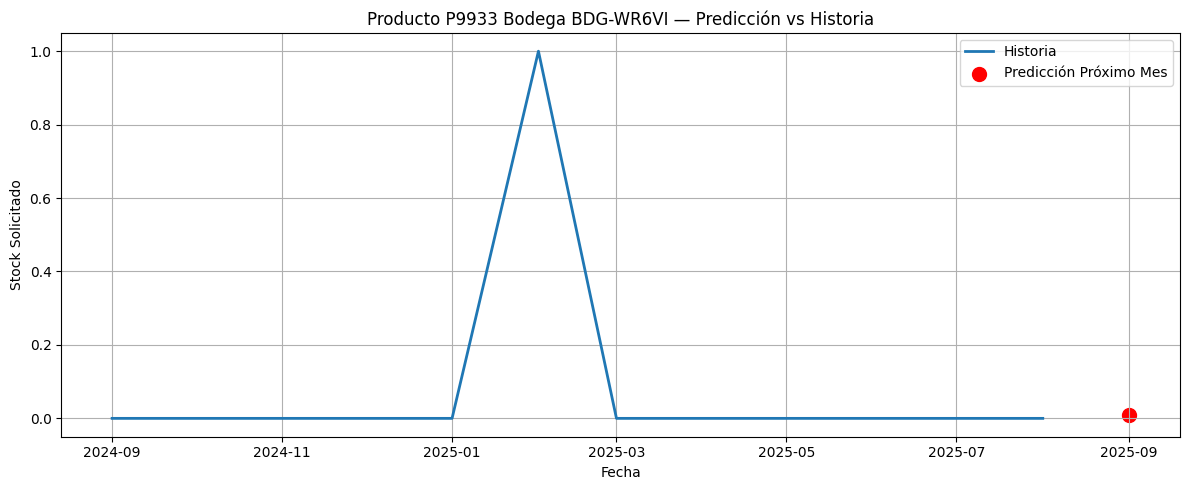

In [41]:
for b in pred_A["bodega"].unique():
    graficar_bodega(dict_series=dict_A_norm, df_pred=pred_A, bodega=b, titulo_prefix="Producto P9933")

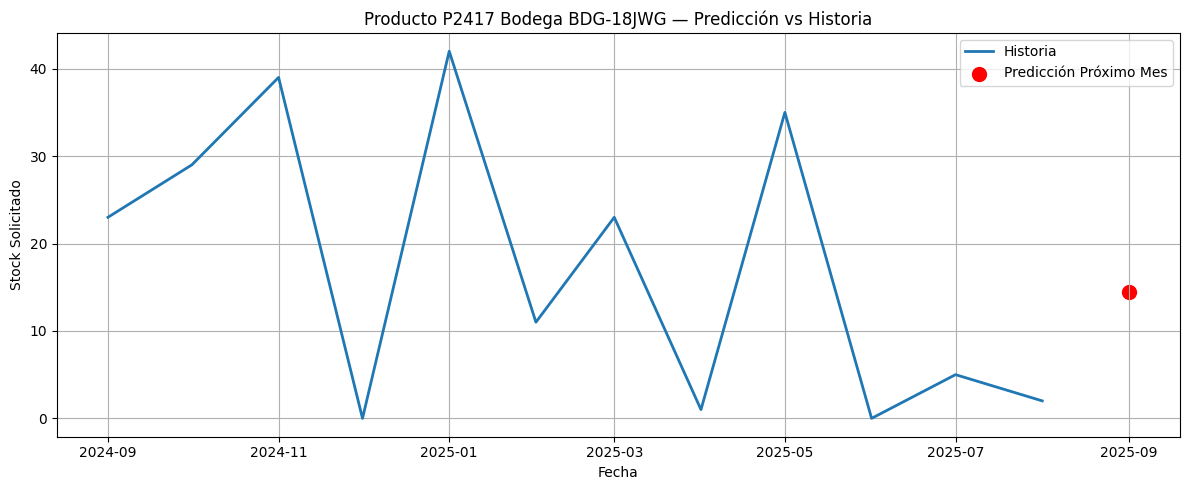

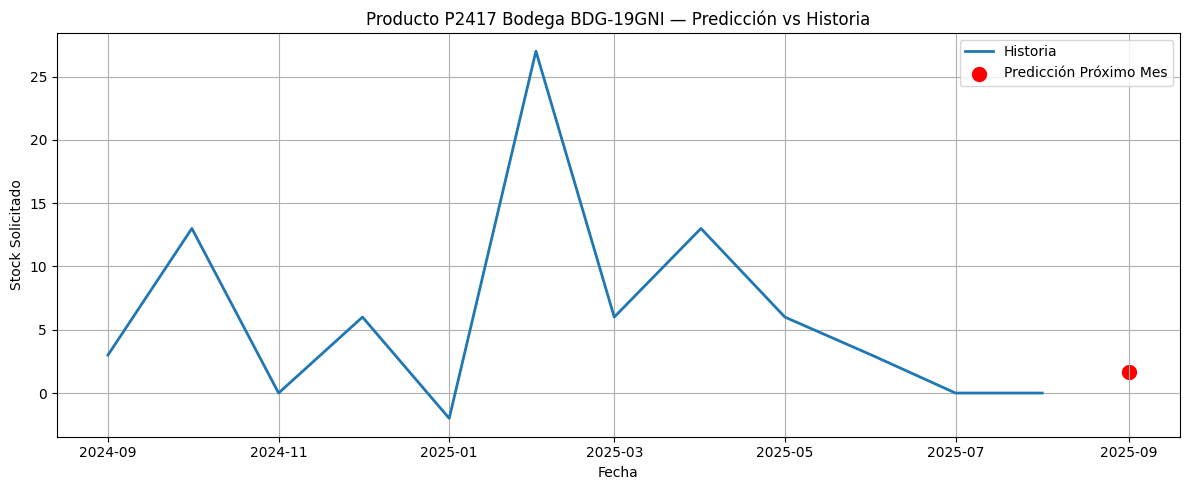

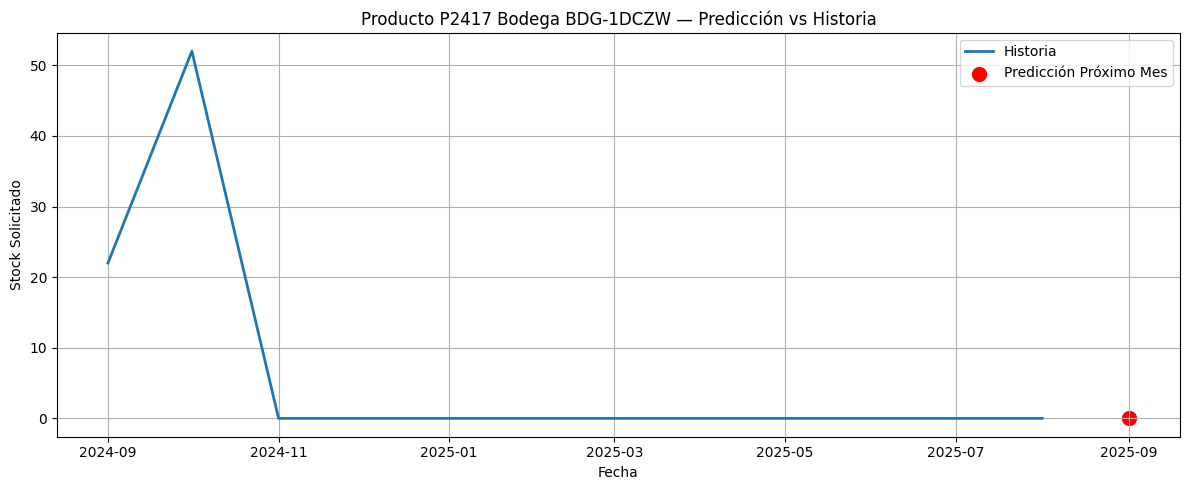

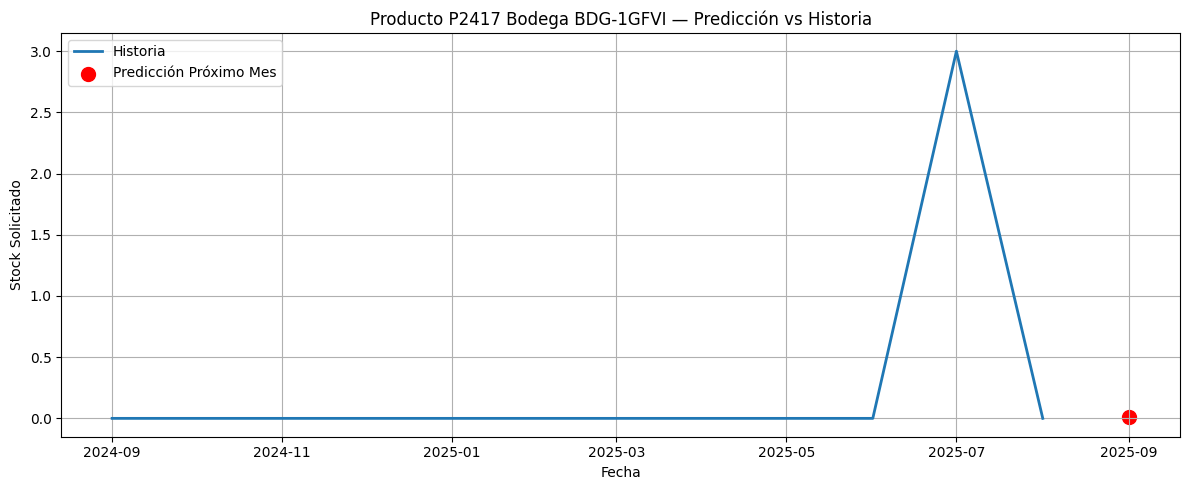

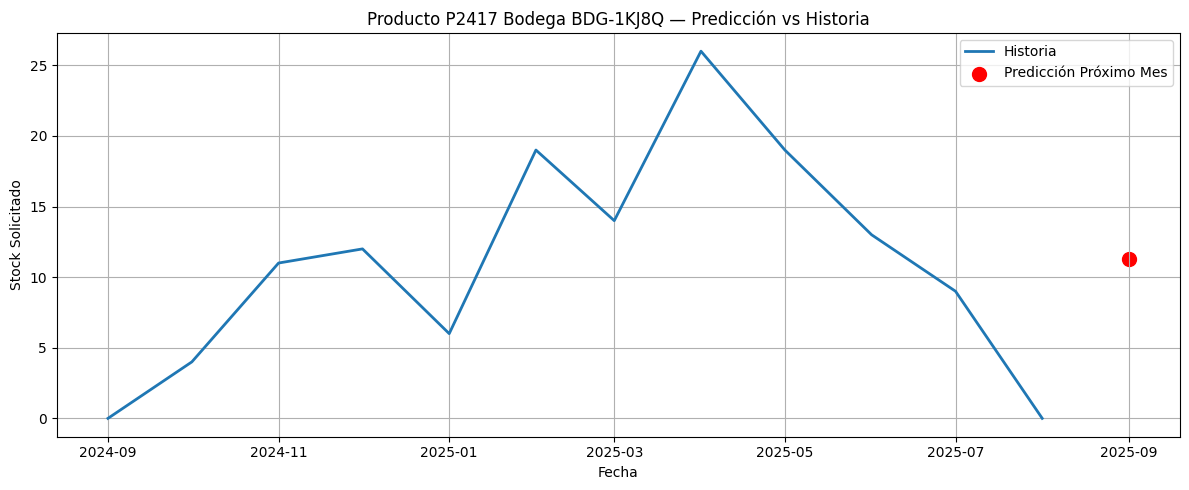

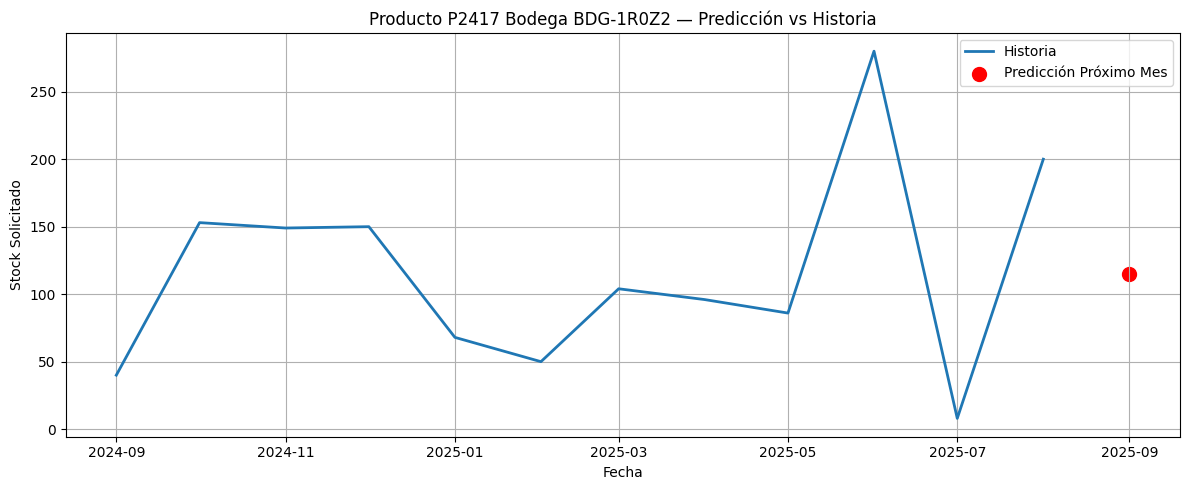

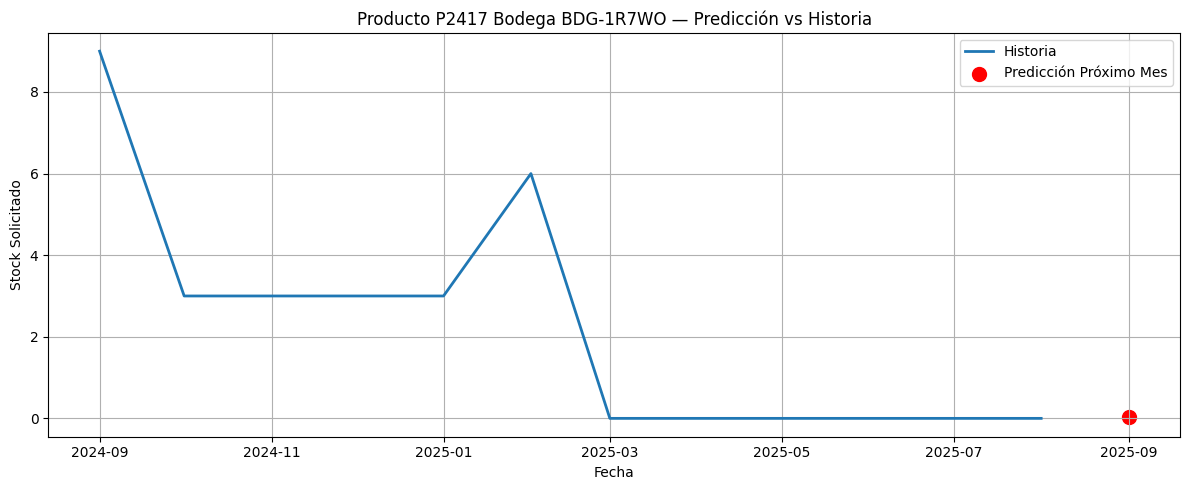

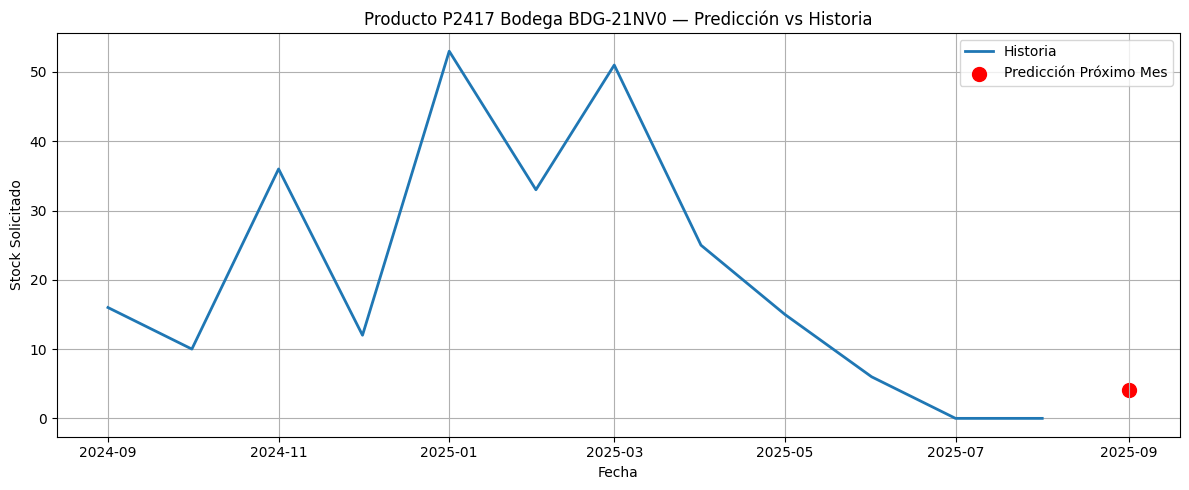

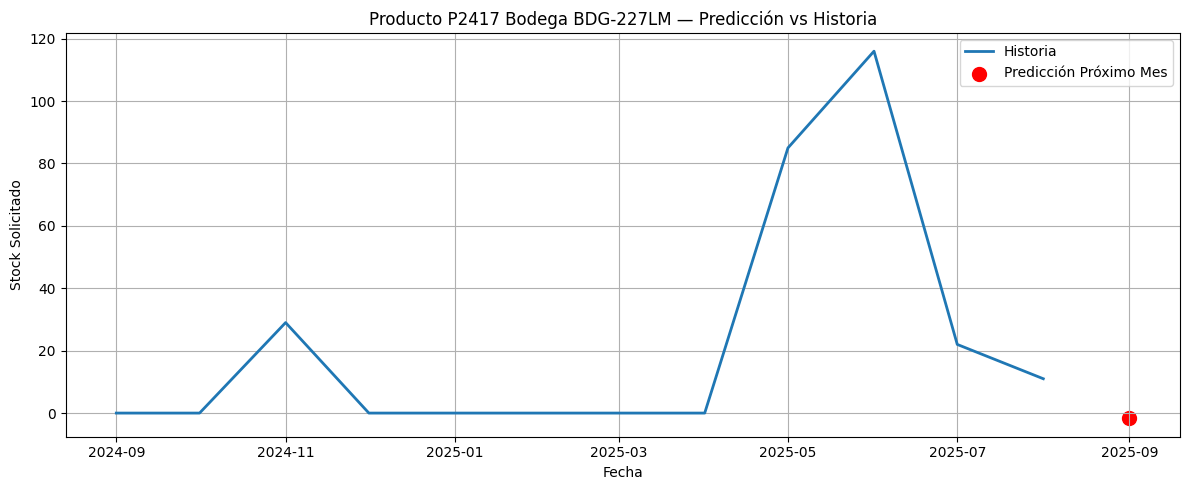

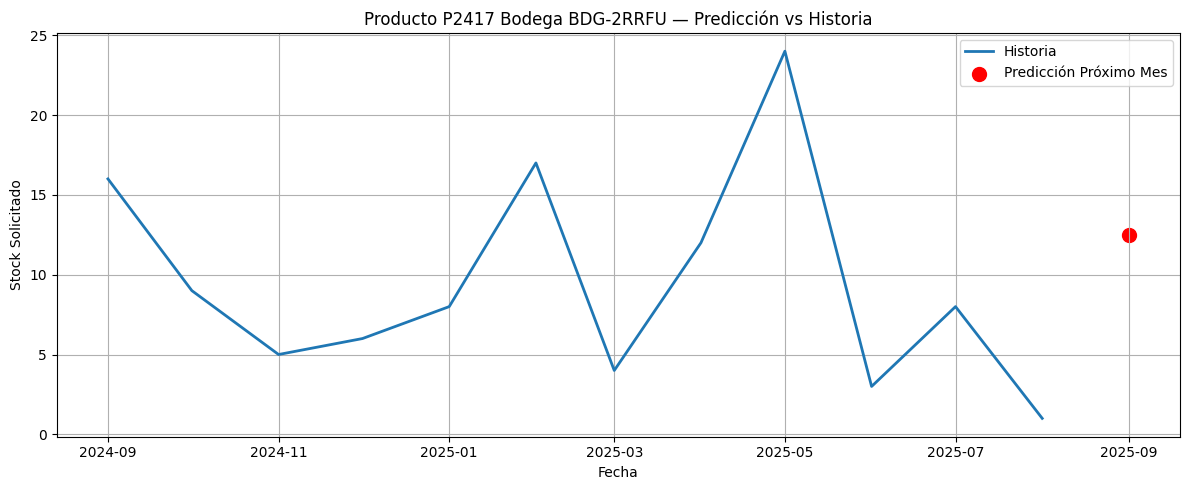

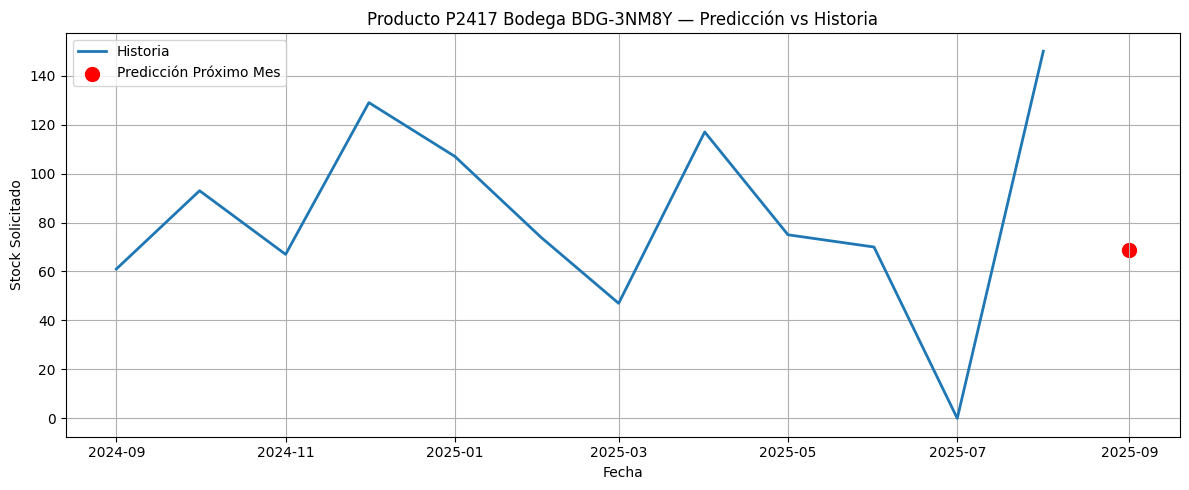

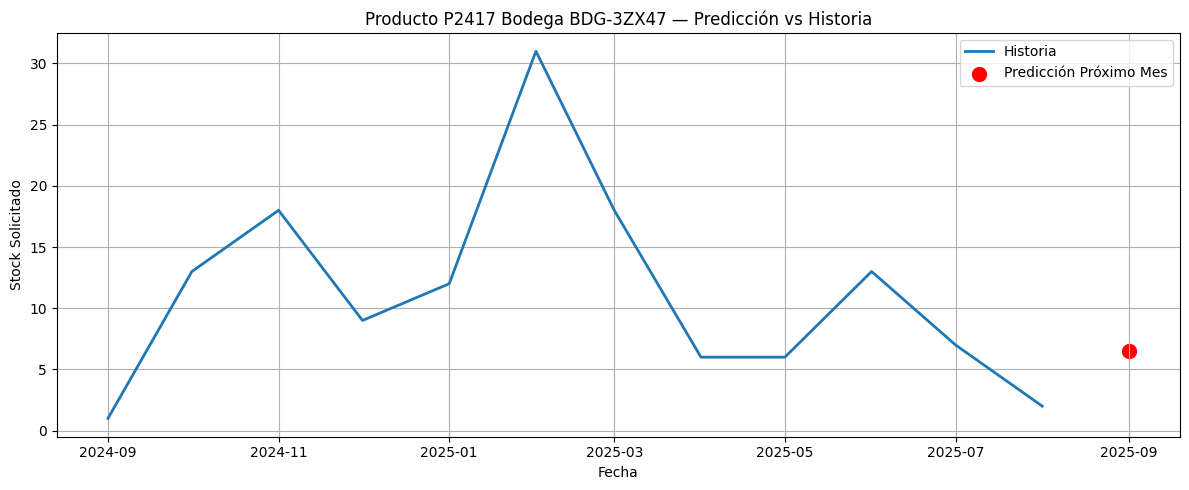

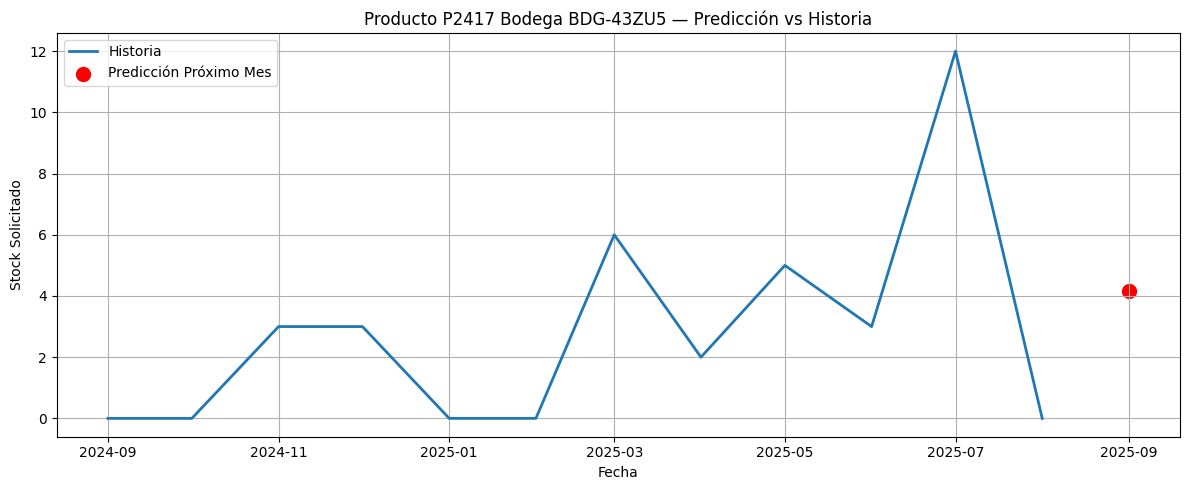

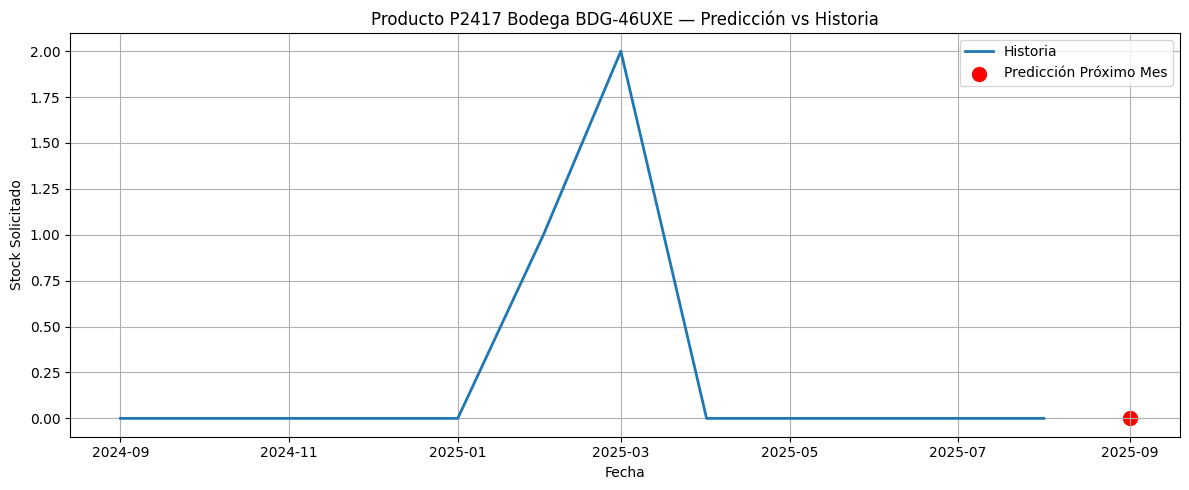

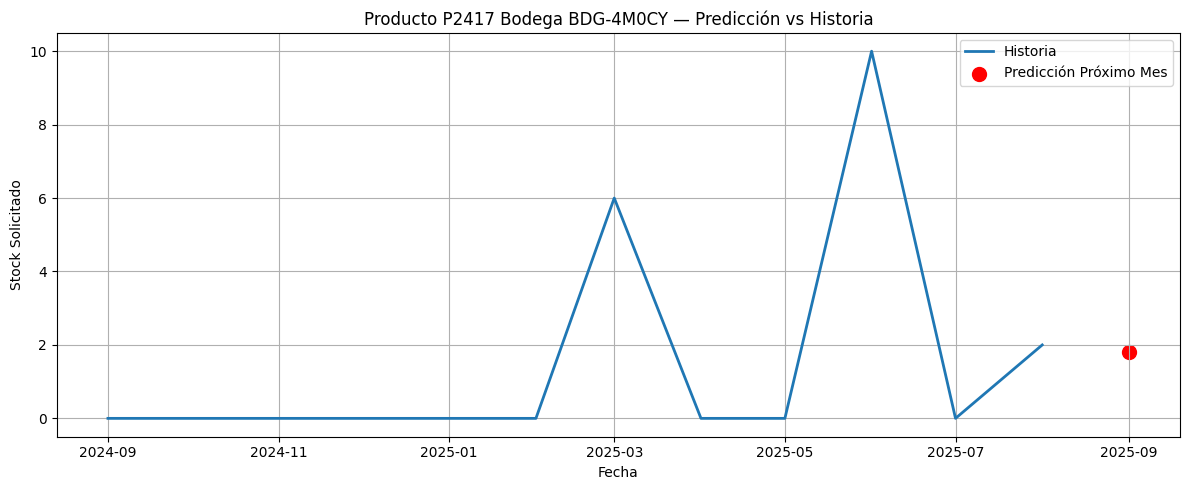

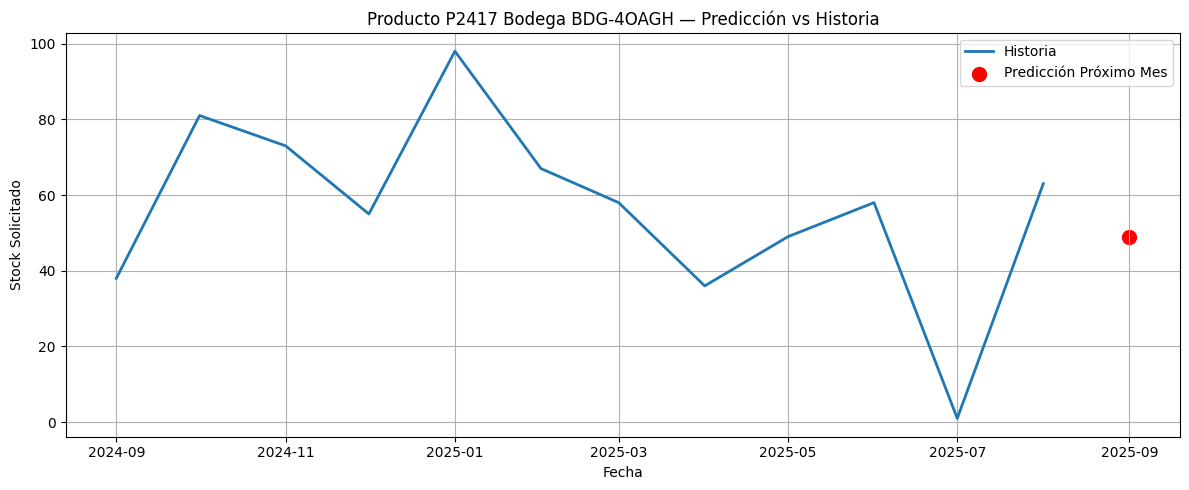

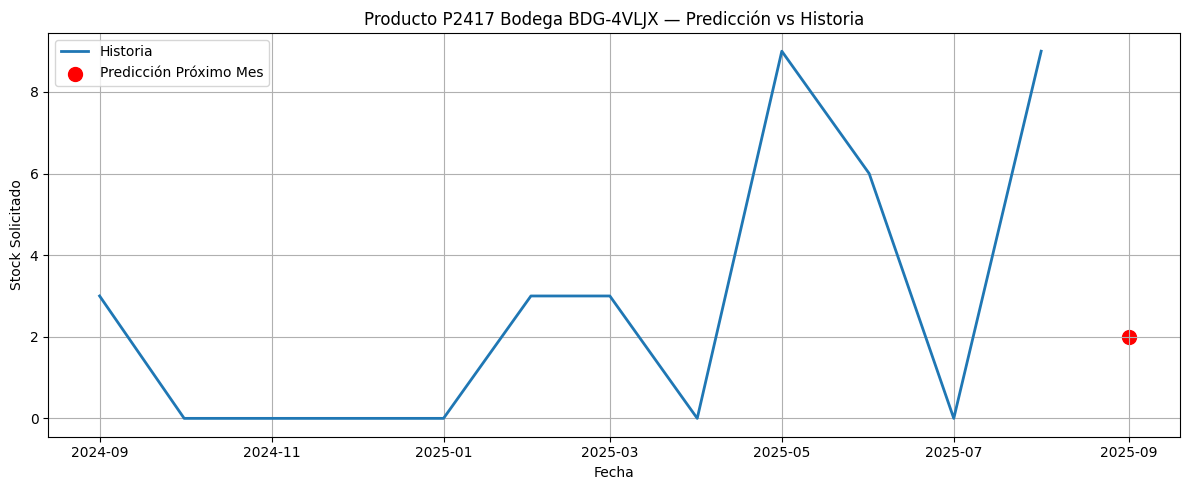

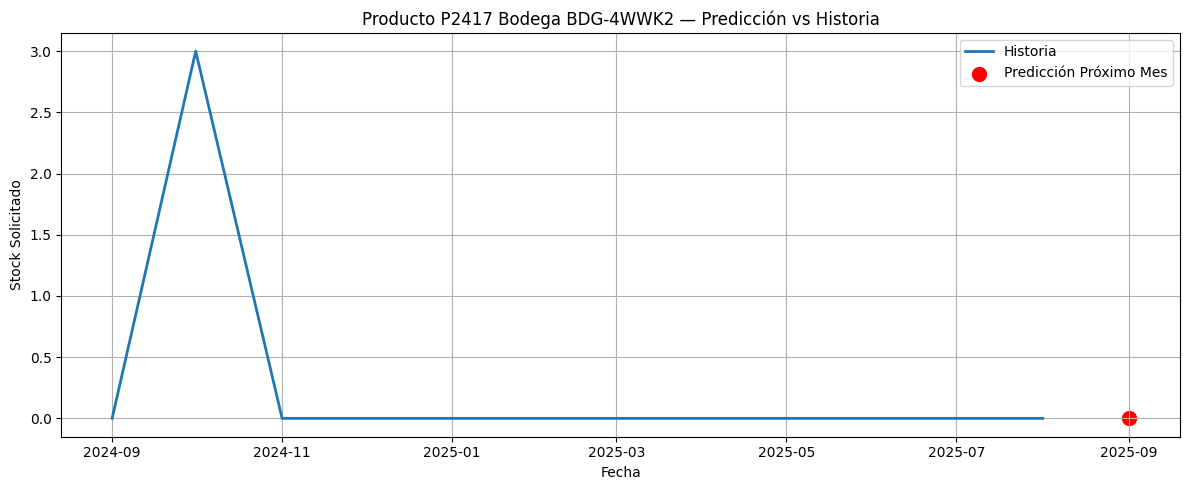

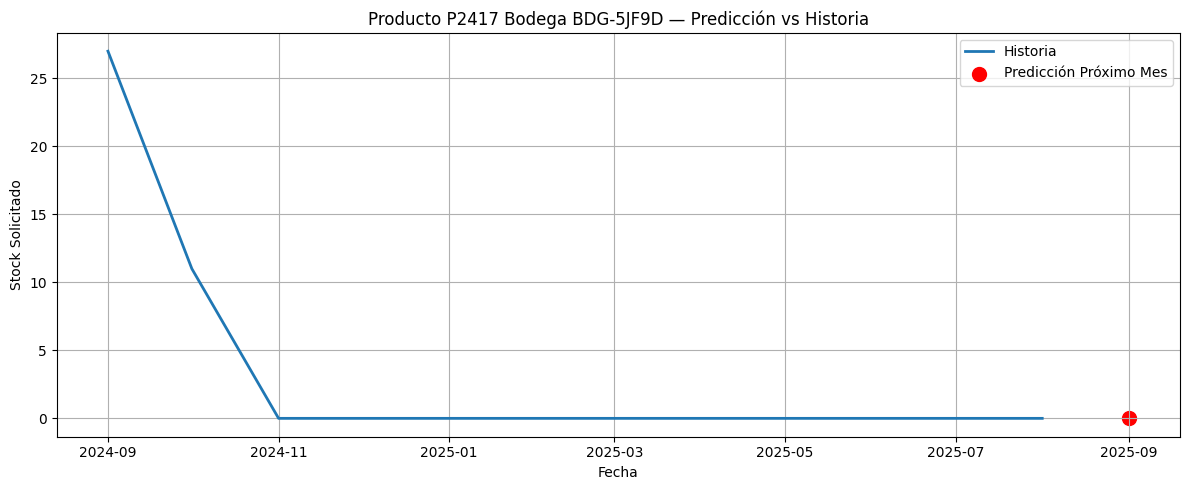

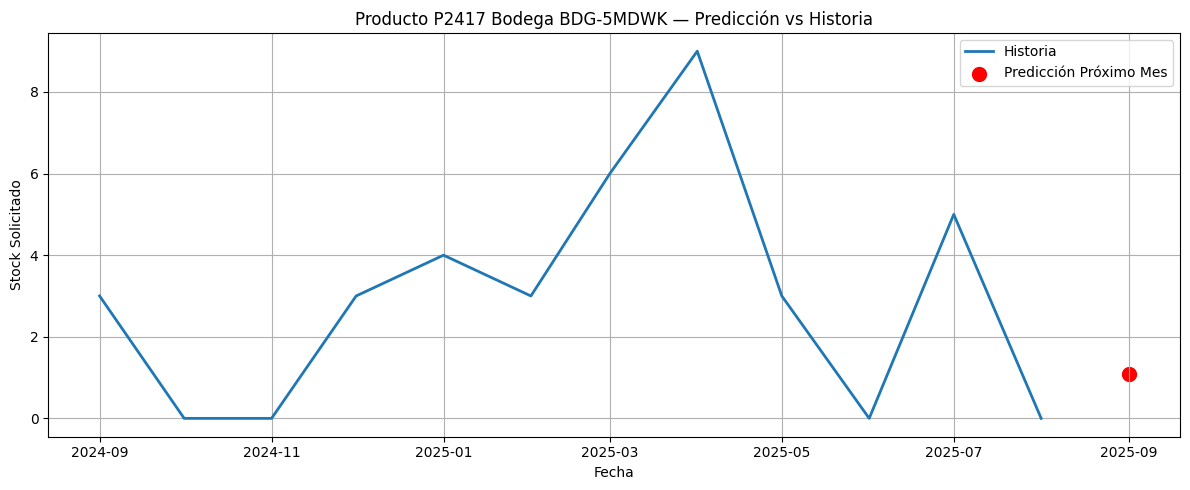

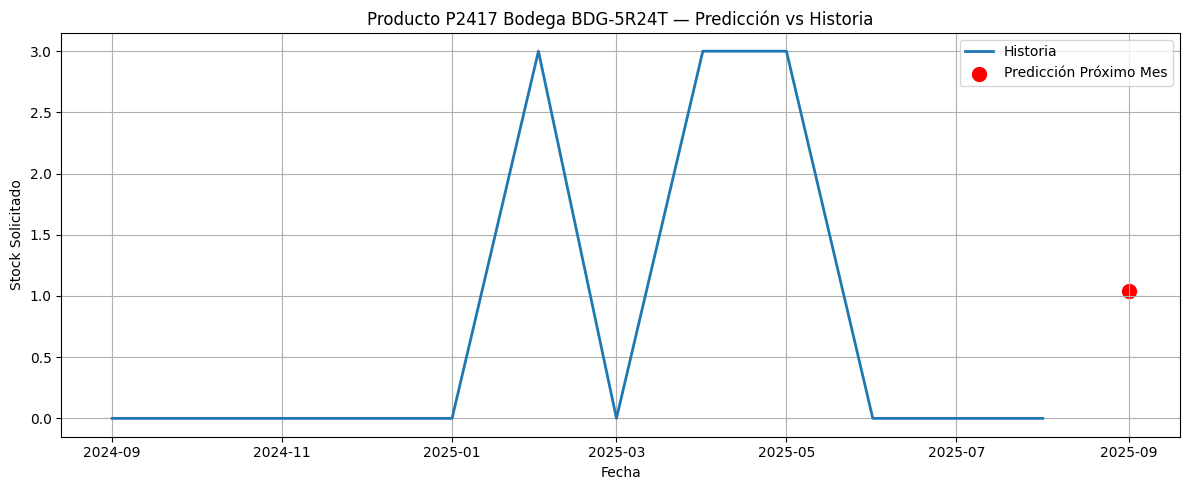

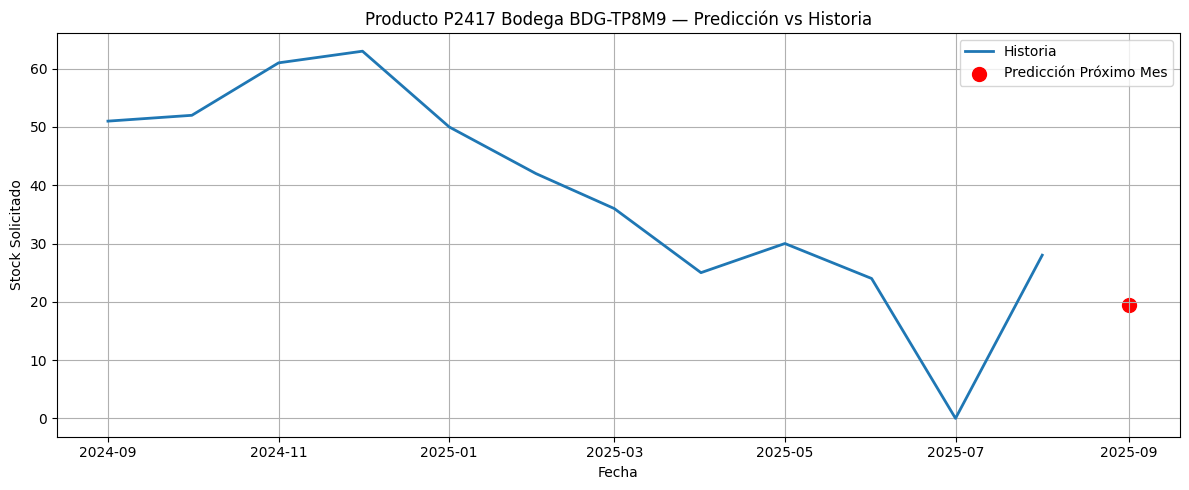

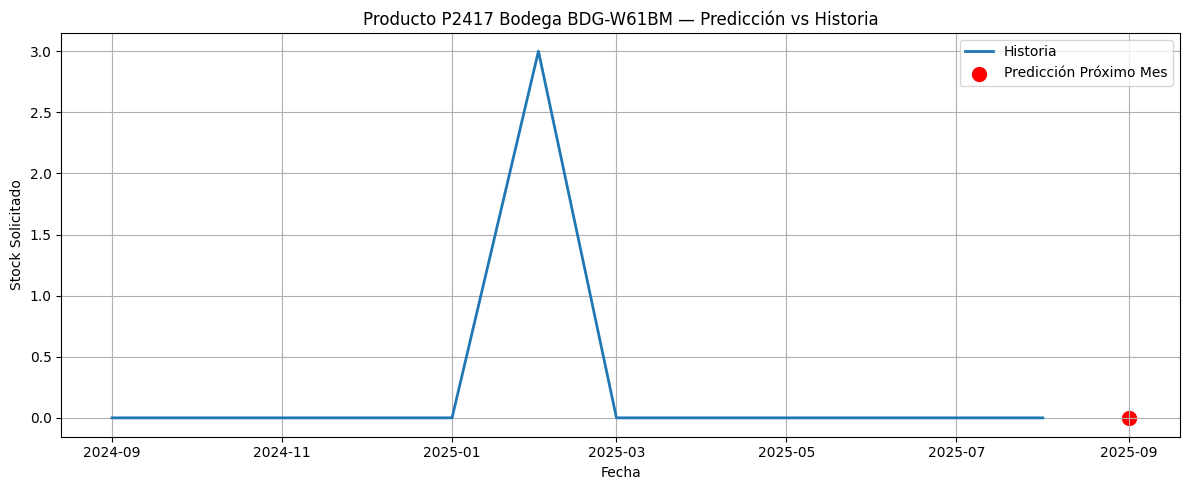

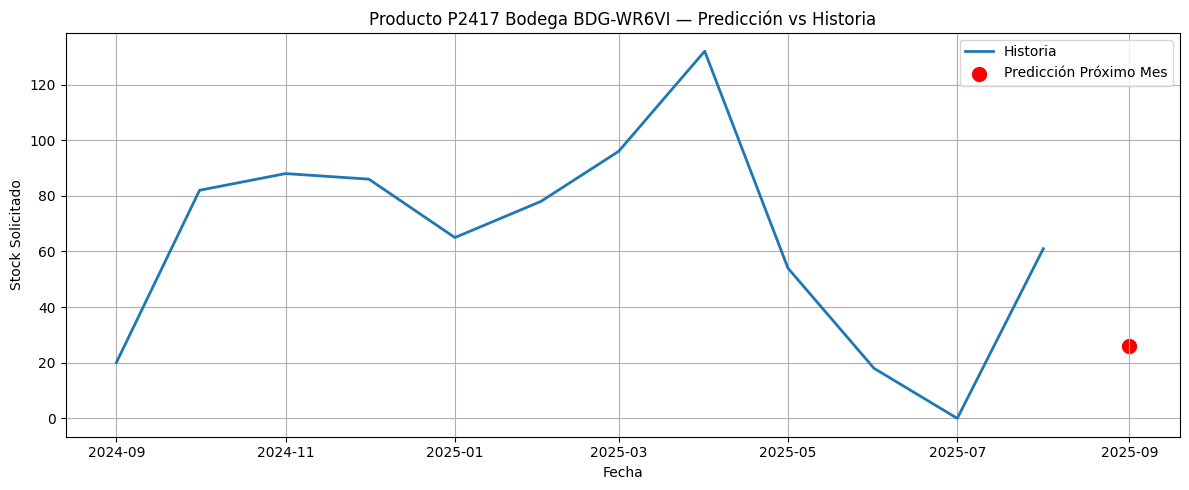

In [42]:
for b in pred_B["bodega"].unique():
    graficar_bodega(dict_series=dict_B_norm, df_pred=pred_B, bodega=b, titulo_prefix="Producto P2417")

In [ ]:
#@13- Guardar el mejor modelo
os.makedirs("modelos_A", exist_ok=True)
os.makedirs("modelos_B", exist_ok=True)

In [ ]:
best_models_A[bodega]
best_models_B[bodega]

In [ ]:
def guardar_modelos(diccionario_modelos, ruta_base):
    """
    Guarda cada modelo del diccionario en una carpeta individual.
    """
    for bodega, modelo in diccionario_modelos.items(): # Changed 'info' to 'modelo' here

        # Crear ruta del modelo por bodega
        ruta_bodega = os.path.join(ruta_base, f"bodega_{bodega}")
        os.makedirs(ruta_bodega, exist_ok=True)

        # Nombre del archivo
        ruta_modelo = os.path.join(ruta_bodega, "best_model.keras")

        # Guardar modelo
        modelo.save(ruta_modelo)

        print(f"✔ Modelo guardado para bodega {bodega} en {ruta_modelo}")

In [ ]:
guardar_modelos(best_models_A, "modelos_A")
guardar_modelos(best_models_B, "modelos_B")